In [482]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor


# Data Import, Inspection, Cleaning

## Describe data, check for missing values, and check for time gaps

In [326]:
energy_data = pd.read_csv("data/energy_demand_weather_hourly_spain/energy_dataset.csv")

energy_data.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  ...  \
count                35046.0                                         0.0  ...   
mean                     0.0                                         NaN  ...   
std                      0.0                                         NaN  ...   
min                      0.0                                         NaN  ...   
25%                      0.0                                         NaN  ...   
50%                      0.0                                         NaN  ...   
75%                      0.0                                         NaN  ...   
max                      0.0                                         NaN  ...   

       generation waste  generation wind offshore  generation wind onshore  \
count      35045.000000                   35046.0             35046.000000   
mean         269.452133                       0.0              5464.479769   
std           50.195536                       0.0              3213.691587   
min            0.000000                       0.0                 0.000000   
25%          240.000000                       0.0              2933.000000   
50%          279.000000                       0.0              4849.000000   
75%          310.000000                       0.0              7398.000000   
max          357.000000                       0.0             17436.000000   

       forecast solar day ahead  forecast wind offshore eday ahead  \
count              35064.000000                                0.0   
mean                1439.066735                                NaN   
std                 1677.703355       

In [327]:
weather_features = pd.read_csv("data/energy_demand_weather_hourly_spain/weather_features.csv")

weather_features.describe()

temp       temp_min       temp_max      pressure  \
count  178396.000000  178396.000000  178396.000000  1.783960e+05   
mean      289.618605     288.330442     291.091267  1.069261e+03   
std         8.026199       7.955491       8.612454  5.969632e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.670000     282.483602     284.650000  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.150000     293.730125     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity    wind_speed       wind_deg        rain_1h  \
count  178396.000000  178396.00000  178396.000000  178396.000000   
mean       68.423457       2.47056     166.591190       0.075492   
std        21.902888       2.09591     116.611927       0.398847   
min         0.000000       0.00000       0.000000       0.000000   
25%        53.000000       1.00000      55.000000       0.000000   
50%        72.000000       2.00000     177.000000       0.000000   
75%        87.000000       4.00000     270.000000       0.000000   
max       100.000000     133.00000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  178396.000000  178396.000000  178396.000000  178396.000000  
mean        0.000380       0.004763      25.073292     759.831902  
std         0.007288       0.222604      30.774129     108.733223  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      20.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

In [328]:
# Check for missing values
print(f"Missing values in energy_data, which has length of {len(energy_data)}:")
print(energy_data.isnull().sum())

print(f"\nMissing values in weather_features, which has length of {len(weather_features)}:")
print(weather_features.isnull().sum())


Missing values in energy_data, which has length of 35064:
time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable               

In [329]:
# Set up the dataset for checking time gaps
# The time is provided in spanish timezone CET
energy_data["time"] = pd.to_datetime(energy_data["time"], utc=True).dt.tz_convert('CET')

# Set time as index for easier slicing & analysis
energy_data.set_index("time", inplace=True)

# Convert and set time index for weather_features, similarly as for energy_data
weather_features["dt_iso"] = pd.to_datetime(weather_features["dt_iso"], utc=True).dt.tz_convert('CET')
weather_features.set_index("dt_iso", inplace=True)

In [330]:
# Check for time gaps in energy_data
energy_time_diff = energy_data.index.to_series().diff().value_counts()
print("Time gaps in energy_data:")
print(energy_time_diff)

# Check for time gaps in weather_features
weather_time_diff = weather_features.index.to_series().diff().value_counts()
print("\nTime gaps in weather_features:")
print(weather_time_diff)


Time gaps in energy_data:
time
0 days 01:00:00    35063
Name: count, dtype: int64

Time gaps in weather_features:
dt_iso
0 days 01:00:00         175315
0 days 00:00:00           3076
-1461 days +01:00:00         4
Name: count, dtype: int64


#### Notes and Observations
- Description of data:
    - energy_data: several columns, like "generation fossil oil shale" or "generation wind offshore" have a min/max and mean values of zero. This means these energy sources likely have negligible usage.
    - energy_data: Outside of the zeroes, the scale of the values in each column varies a lot -- some columns only max around 350 (generation waste) whereas others max around 20K (generation fossil gas). This means we will need to normalize/scale the data.
    - weather_features: The scale of the values in each column varies a lot, some columns only max around 2.3 (rain_3h) whereas others max around 1e6 (pressure). This means we will need to normalize/scale the data.
- Missing data:
    - energy_data has ~18/19 missing observations throughout the "generation" columns. I wonder if these are overlapping across columns. This is not a huge amount but needs addressing. 
    - in energy_data, both "generation hydro pumped storage aggregated" and "forecast wind offshore eday ahead" have no data, as the number of missing observations matches the length of the dataset. These can be excluded from analysis.
    - weather_features has no missing data!
- Time gaps:
    - energy_data: appears to have no time gaps greater than an hour
    - weather_features: appears to have ~3000 observations with zero hour time gaps-- maybe these are duplicates or errors. 
    - weather_features: Also has 4 observations with -1461 day gaps, not clear what this means.

## Investigate missing data and time gaps further

In [331]:
# Investigate missing data, part 2: Do missing observations in energy_data 
# overlap across columns?

# Filter out columns where missing values are equal to the dataset length
relevant_columns = energy_data.columns[energy_data.isnull().sum() < len(energy_data)]

# Check overlapping missing values across relevant columns
overlapping_missing = energy_data[relevant_columns].isnull().all(axis=1)

print("Rows where multiple 'generation' columns have missing values:")
print(energy_data[overlapping_missing])


Rows where multiple 'generation' columns have missing values:
Empty DataFrame
Columns: [generation biomass, generation fossil brown coal/lignite, generation fossil coal-derived gas, generation fossil gas, generation fossil hard coal, generation fossil oil, generation fossil oil shale, generation fossil peat, generation geothermal, generation hydro pumped storage aggregated, generation hydro pumped storage consumption, generation hydro run-of-river and poundage, generation hydro water reservoir, generation marine, generation nuclear, generation other, generation other renewable, generation solar, generation waste, generation wind offshore, generation wind onshore, forecast solar day ahead, forecast wind offshore eday ahead, forecast wind onshore day ahead, total load forecast, total load actual, price day ahead, price actual]
Index: []

[0 rows x 28 columns]


--> It appears that the missing values occur across different timestamps and are scattered across the rows. 

In [332]:
# Investigate the time gaps in weather_features, part 2

# Check zero-hour time gaps
zero_hour_gaps = weather_features.index.to_series().diff() == pd.Timedelta(hours=0)
print("Rows with zero-hour time gaps:")
print(weather_features[zero_hour_gaps])

# Check negative day gaps
negative_day_gaps = weather_features.index.to_series().diff() == pd.Timedelta(days=-1461)
print("Rows with -1461 day gaps:")
print(weather_features[negative_day_gaps])


Rows with zero-hour time gaps:
                          city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                       
2015-01-06 04:00:00+01:00  Valencia  273.142   273.142   273.142       995   
2015-06-15 21:00:00+02:00  Valencia  289.610   288.650   290.930      1018   
2015-06-15 22:00:00+02:00  Valencia  289.240   288.150   290.370      1018   
2015-07-18 19:00:00+02:00  Valencia  299.770   298.750   300.930      1013   
2015-07-31 23:00:00+02:00  Valencia  295.890   293.710   297.590      1009   
...                             ...      ...       ...       ...       ...   
2018-12-17 08:00:00+01:00   Seville  282.830   282.150   283.150      1029   
2018-12-19 08:00:00+01:00   Seville  286.800   286.150   287.150      1024   
2018-12-19 09:00:00+01:00   Seville  284.930   283.150   286.150      1024   
2018-12-26 11:00:00+01:00   Seville  280.740   279.150   283.150      1030   
2018-12-26 12:00:00+01:00   Sevil

In [333]:
repeated_times = weather_features[weather_features.index.duplicated(keep=False)]
city_counts_at_repeated_times = repeated_times.groupby(repeated_times.index).size()
print(city_counts_at_repeated_times)
print(city_counts_at_repeated_times.unique())

dt_iso
2015-01-01 00:00:00+01:00    5
2015-01-01 01:00:00+01:00    5
2015-01-01 02:00:00+01:00    5
2015-01-01 03:00:00+01:00    5
2015-01-01 04:00:00+01:00    5
                            ..
2018-12-31 19:00:00+01:00    5
2018-12-31 20:00:00+01:00    5
2018-12-31 21:00:00+01:00    5
2018-12-31 22:00:00+01:00    5
2018-12-31 23:00:00+01:00    5
Length: 35064, dtype: int64
[ 5  6  8  7 10  9]


In [334]:
weather_features['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

--> There appear to be duplicated timestamps throughout the dataset. Given there are 5 unique cities, it is alarming that
there can be >5 duplicated timestamps

In [335]:
example_timestamp = city_counts_at_repeated_times[city_counts_at_repeated_times == 10].index[0]
print(weather_features.loc[example_timestamp])


                            city_name    temp  temp_min  temp_max  pressure  \
dt_iso                                                                        
2015-10-01 02:00:00+02:00    Valencia  289.74    286.48    292.04      1021   
2015-10-01 02:00:00+02:00    Valencia  289.74    286.48    292.04      1021   
2015-10-01 02:00:00+02:00      Madrid  286.75    285.93    287.15      1021   
2015-10-01 02:00:00+02:00      Madrid  286.75    285.93    287.15      1021   
2015-10-01 02:00:00+02:00      Bilbao  285.99    282.15    288.15      1021   
2015-10-01 02:00:00+02:00      Bilbao  285.99    282.15    288.15      1021   
2015-10-01 02:00:00+02:00   Barcelona  288.68    284.82    290.93      1020   
2015-10-01 02:00:00+02:00   Barcelona  288.68    284.82    290.93      1020   
2015-10-01 02:00:00+02:00     Seville  295.50    291.15    302.15      1019   
2015-10-01 02:00:00+02:00     Seville  295.50    291.15    302.15      1019   

                           humidity  wind_speed  wi

--> The culprit is that there are exact rows duplicated. This needs to be addressed in pre-processing

In [336]:
# Investigate the time gap of -1461 days and 1 hour in the weather_features data
peculiar_rows = weather_features[weather_features.index.to_series().diff() == pd.Timedelta('-1461 days +01:00:00')]
print(peculiar_rows)

                            city_name        temp    temp_min    temp_max  \
dt_iso                                                                      
2015-01-01 00:00:00+01:00      Madrid  267.325000  267.325000  267.325000   
2015-01-01 00:00:00+01:00      Bilbao  269.657312  269.657312  269.657312   
2015-01-01 00:00:00+01:00   Barcelona  281.625000  281.625000  281.625000   
2015-01-01 00:00:00+01:00     Seville  273.375000  273.375000  273.375000   

                           pressure  humidity  wind_speed  wind_deg  rain_1h  \
dt_iso                                                                         
2015-01-01 00:00:00+01:00       971        63           1       309      0.0   
2015-01-01 00:00:00+01:00      1036        97           0       226      0.0   
2015-01-01 00:00:00+01:00      1035       100           7        58      0.0   
2015-01-01 00:00:00+01:00      1039        75           1        21      0.0   

                           rain_3h  snow_3h  clouds_all 

--> Peculiar rows with -1461 days and 1 hour can be explained by the 5 unique cities. 

#### Data Inspection Notes for Cleaning:
Handling Missing Values:
- Columns with No Data: Columns such as "generation hydro pumped storage aggregated" and "forecast wind offshore eday ahead" have no data throughout the entire dataset and should be dropped.
- Isolated Missing Values: For columns with only a few missing values (like 18 or 19 missing observations, at most 36), we can choose to fill them using a method that makes sense (mean, median, forward fill, etc.). However since they are so few in number relative to the total data frame length (36K rows), we can leave this as is for now.

Time Gaps:
- For energy_data, no action is needed as there are no significant time gaps.
- For weather_features, remove rows that are exact duplicates across all columns. This will address issues like the repeated Valencia data point shown above.

#### Data Inspection Notes for Preprocessing:
Timestamp alignment:
- Could be tricky given that there are 5 cities in the weather_feature dataset. If I want to align with energy_data, I may need to aggregate weather_feature and/or pivot the data so that each city has the same number of timestamps (and duplicate the columns). For now, lets leave it as is. 

Data Scaling:
- Significant variations in scale across the columns in both datasets may need to be normalized/standardized
- Columns with zeroes can be removed

# Data Cleaning

In [337]:
# Handling Missing Values
# Drop columns with no data
cols_to_drop = ["generation hydro pumped storage aggregated", "forecast wind offshore eday ahead"]
energy_data = energy_data.drop(columns=cols_to_drop, errors='ignore')

# Time Gaps
# Remove exact duplicate rows from weather_features
weather_features = weather_features.drop_duplicates()


# Exploratory Data Analysis (EDA)
## Patterns in Energy Consumption Over Time

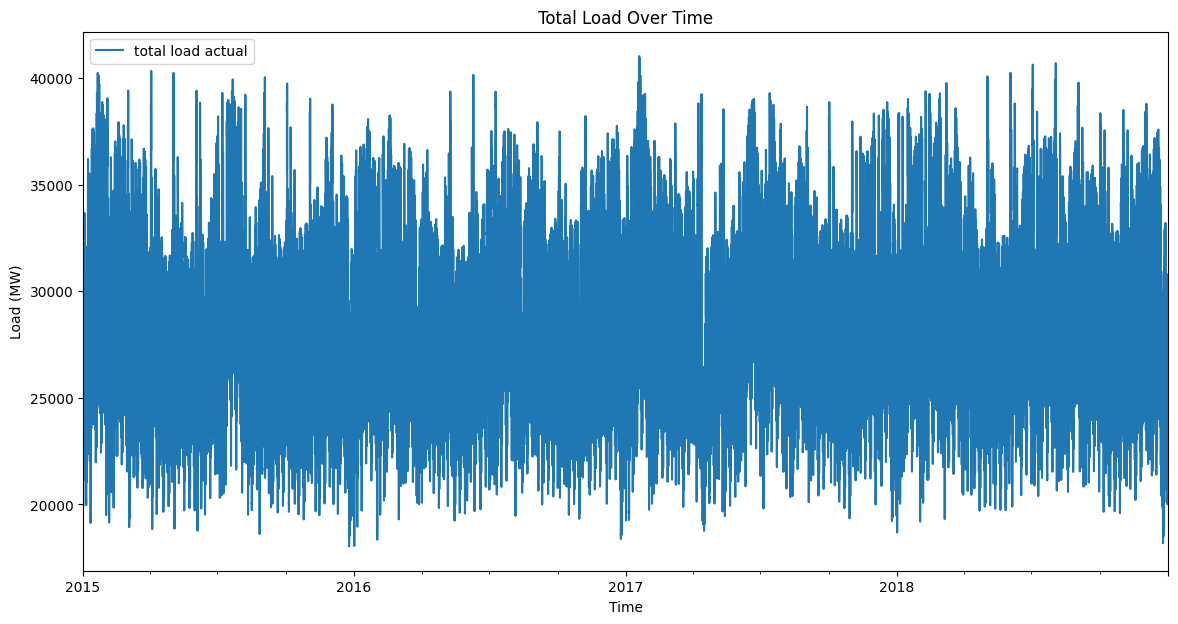

In [338]:
# General plot of total load over time
plt.figure(figsize=(14, 7))
energy_data.plot(y="total load actual", ax=plt.gca())
plt.title("Total Load Over Time")
plt.ylabel("Load (MW)")
plt.xlabel("Time")
plt.show()

In [339]:
energy_data.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual'],
      dtype='object')

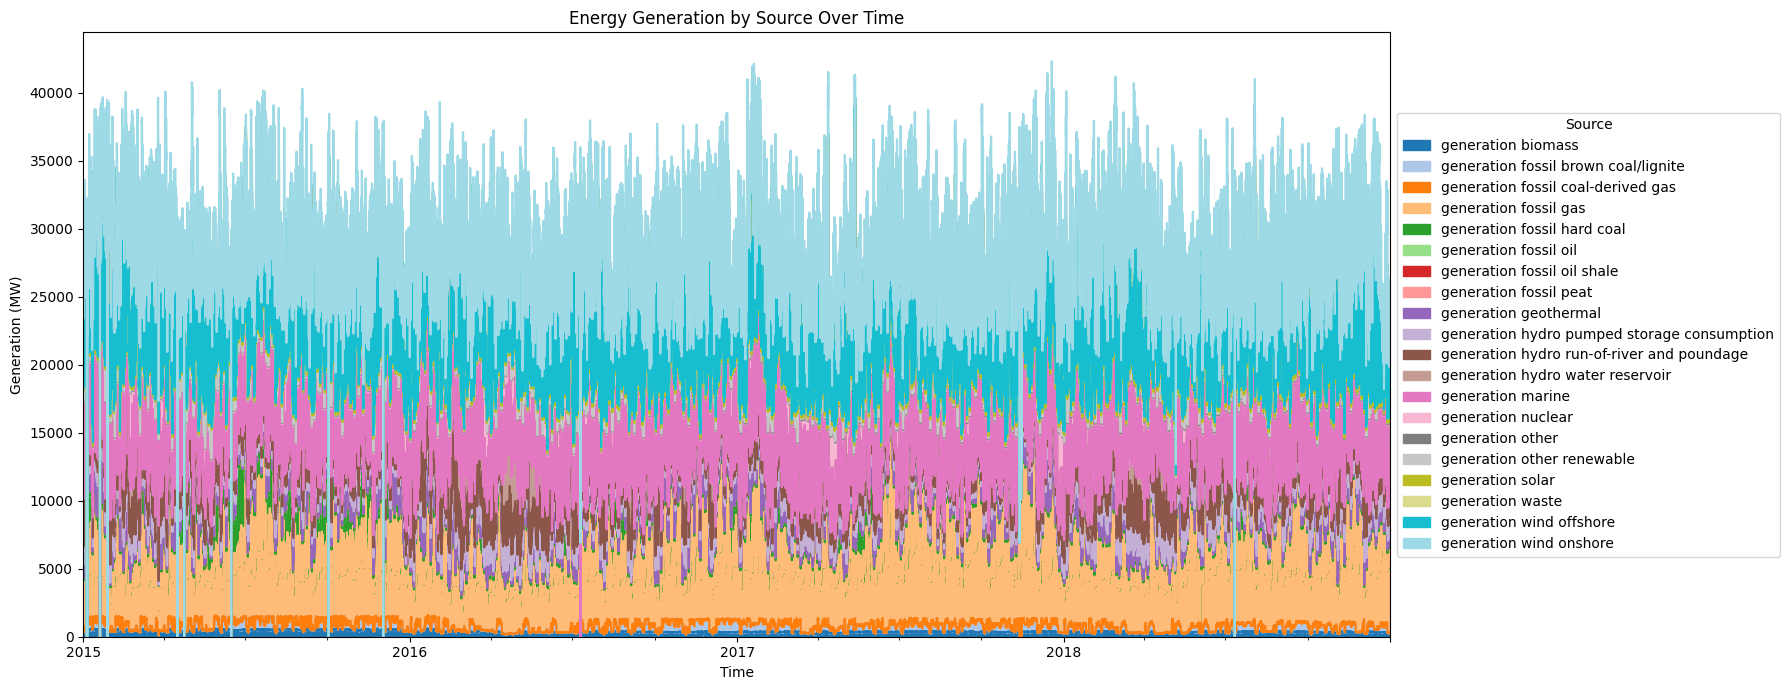

In [340]:
# Create dataframe of only the energy sources
energy_sources = energy_data.drop(columns=["forecast solar day ahead", 
                                           'forecast wind onshore day ahead', 'total load forecast', 
                                           "total load actual", 'price day ahead','price actual'])


# Define a color map - 'tab20' is a qualitative color map suitable for different categories
colors = plt.cm.tab20(np.linspace(0, 1, len(energy_sources.columns)))

plt.figure(figsize=(18, 7))
ax = energy_sources.plot.area(stacked=True, color=colors, ax=plt.gca())

# Place the legend outside the plot
ax.legend(title="Source", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Energy Generation by Source Over Time")
plt.ylabel("Generation (MW)")
plt.xlabel("Time")
plt.tight_layout()  # Ensure the plot fits well even with the legend outside
plt.show()

In [341]:
# Looking at the above plot, it may make sense to group more broadly- by fossil fuel, hydro, etc
print(energy_sources.columns)

# Regrouping data
energy_sources_grouped = pd.DataFrame({
    "Fossil Fuels": energy_sources[['generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 
                                    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 
                                    'generation fossil oil shale', 'generation fossil peat']].sum(axis=1),
    "Hydro": energy_sources[['generation hydro pumped storage consumption',
                             'generation hydro run-of-river and poundage', 'generation hydro water reservoir']].sum(axis=1),
    "Wind & Solar": energy_sources[['generation wind offshore', 'generation wind onshore', 'generation solar', 
                                    'generation other renewable']].sum(axis=1),
    "Other": energy_sources[['generation biomass', 'generation geothermal', 'generation marine', 
                             'generation other', 'generation waste']].sum(axis=1),
    "Nuclear": energy_sources['generation nuclear']
})


Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore'],
      dtype='object')


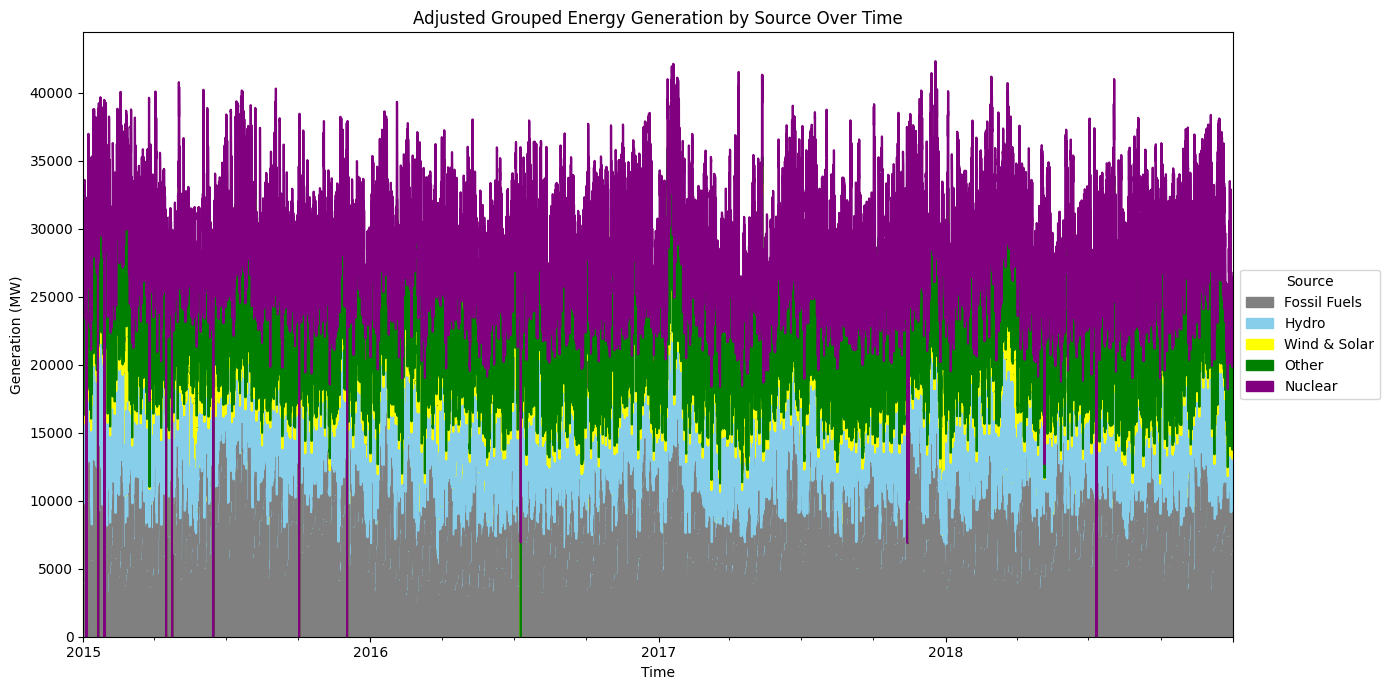

In [342]:
# Plotting the regrouped data
# Custom color mapping
custom_colors = {
    "Fossil Fuels": "gray",
    "Hydro": "skyblue",
    "Wind & Solar": "yellow",
    "Other": "green",
    "Nuclear": "purple"
}

plt.figure(figsize=(14, 7))
ax = energy_sources_grouped.plot.area(stacked=True, color=[custom_colors[col] for col in energy_sources_grouped.columns], ax=plt.gca())
ax.legend(title="Source", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Adjusted Grouped Energy Generation by Source Over Time")
plt.ylabel("Generation (MW)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


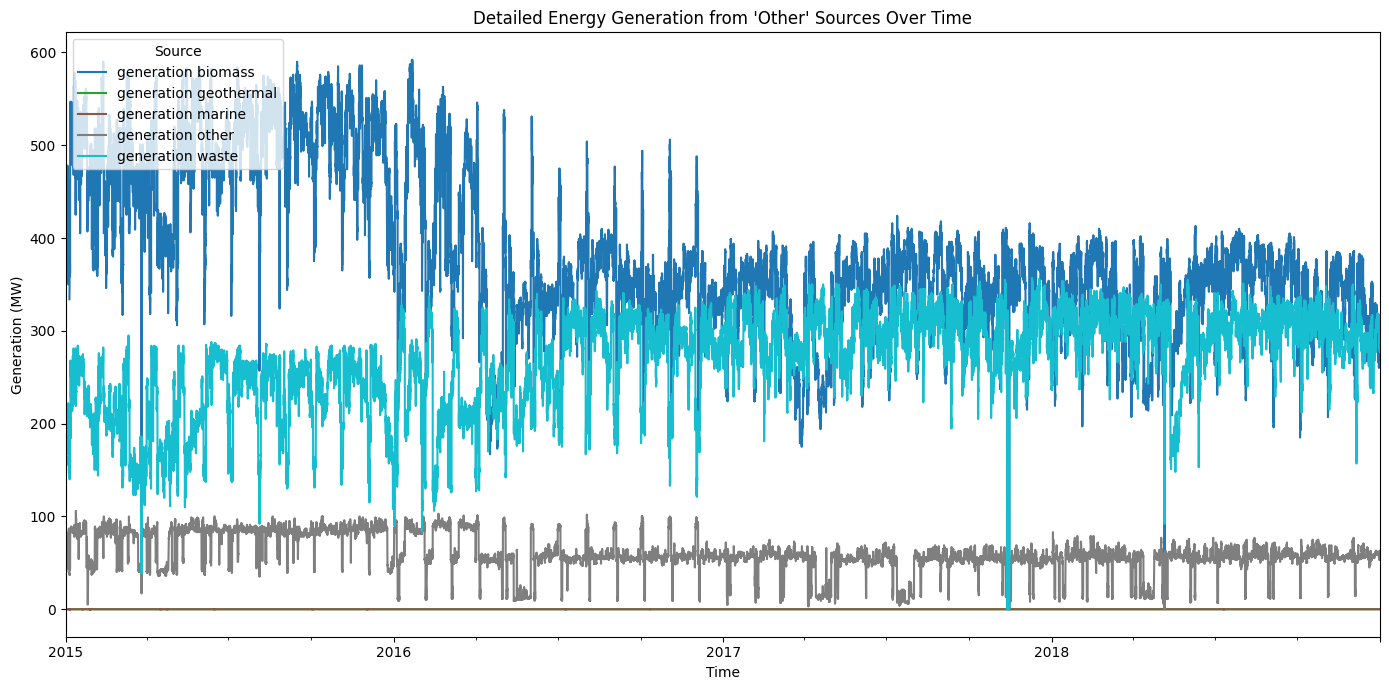

In [343]:
# The "Other" category is a larger fraction than expected, so let's zoom in on just the "Other" energy sources
# Extracting the "Other" category data
other_sources = energy_sources[['generation biomass', 'generation geothermal', 'generation marine', 
                                'generation other', 'generation waste']]

# Plotting
plt.figure(figsize=(14, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(other_sources.columns)))
other_sources.plot(ax=plt.gca(), color=colors)

plt.title("Detailed Energy Generation from 'Other' Sources Over Time")
plt.ylabel("Generation (MW)")
plt.xlabel("Time")
plt.legend(title="Source", loc="upper left")
plt.tight_layout()
plt.show()


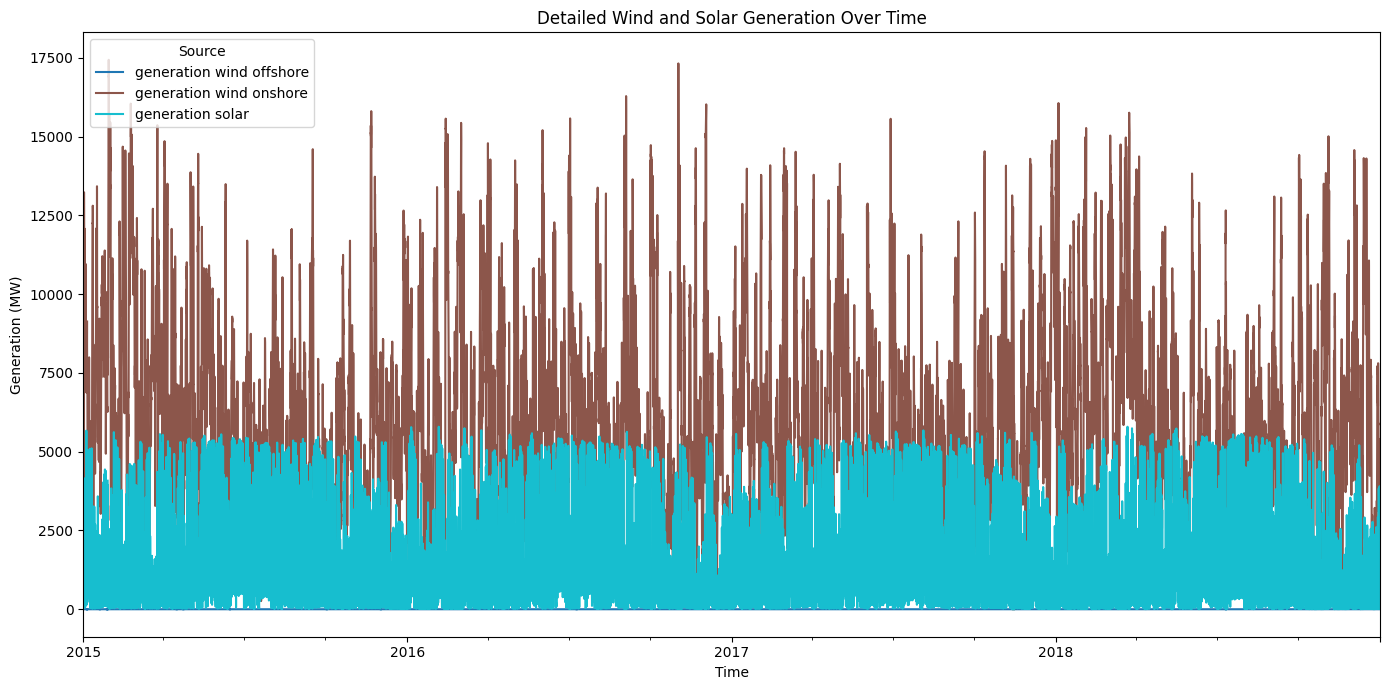

In [344]:
# Out of curiousity, I want to zoom in on the wind and solar generation sources

wind_and_solar_separate = energy_sources[["generation wind offshore", "generation wind onshore", "generation solar"]]

plt.figure(figsize=(14, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(wind_and_solar_separate.columns)))
wind_and_solar_separate.plot(ax=plt.gca(), color=colors)

plt.title("Detailed Wind and Solar Generation Over Time")
plt.ylabel("Generation (MW)")
plt.xlabel("Time")
plt.legend(title="Source", loc="upper left")
plt.tight_layout()
plt.show()


In [345]:
total_generation = energy_sources_grouped.sum(axis=1)
wind_solar = energy_sources_grouped["Wind & Solar"]
fraction_wind_solar = wind_solar / total_generation
dominant_time = fraction_wind_solar.idxmax()

print(f"Wind & Solar had the largest fraction of energy generation on {dominant_time.strftime('%Y-%m-%d')} with a fraction of {fraction_wind_solar[dominant_time]:.2%}.")


Wind & Solar had the largest fraction of energy generation on 2016-07-02 with a fraction of 57.63%.


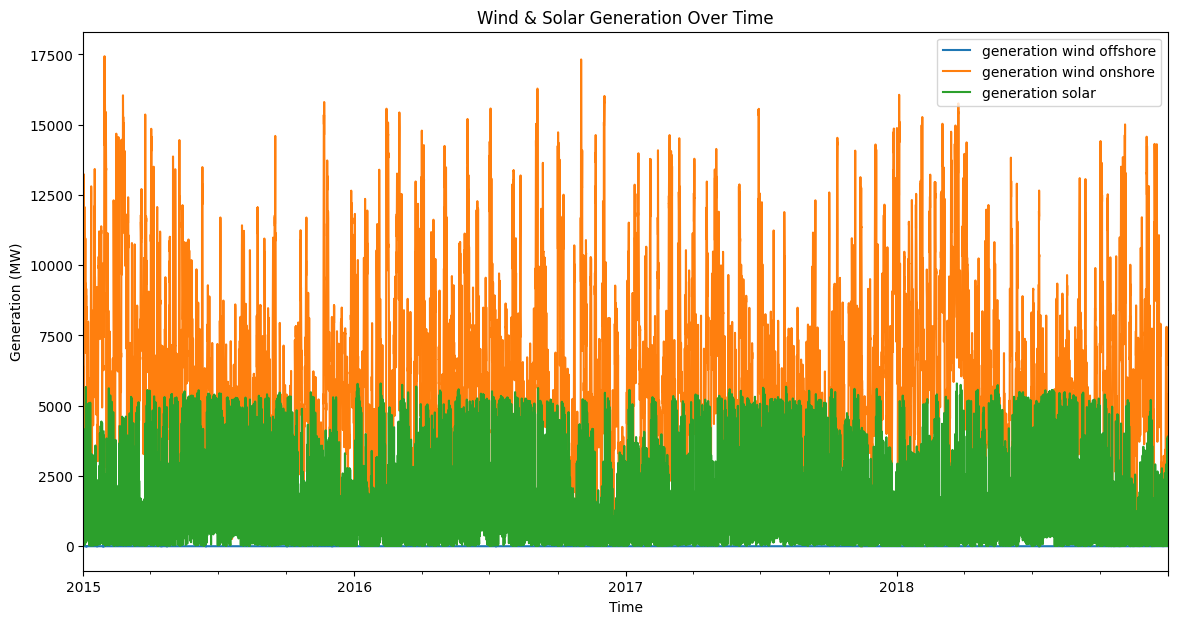

In [346]:
wind_and_solar_separate.plot(figsize=(14, 7))
plt.title("Wind & Solar Generation Over Time")
plt.ylabel("Generation (MW)")
plt.xlabel("Time")
plt.show()

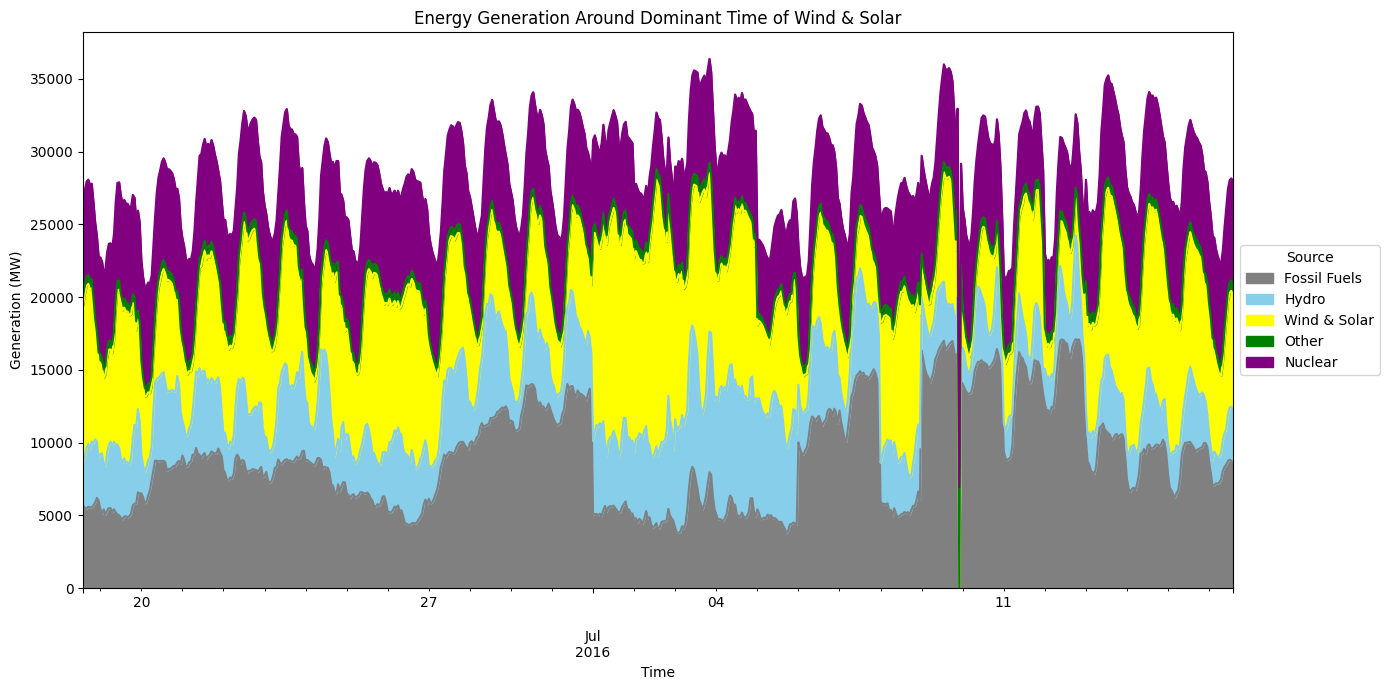

In [347]:
# Extract the time window of interest
start_date = dominant_time - timedelta(days=14)   # Two weeks before the dominant time
end_date = dominant_time + timedelta(days=14)    # Two weeks after the dominant time
subset_data = energy_sources_grouped.loc[start_date:end_date]

# Plotting
colors = plt.cm.tab10(np.linspace(0, 1, len(subset_data.columns)))

plt.figure(figsize=(14, 7))
ax = subset_data.plot.area(stacked=True, color=[custom_colors[col] for col in energy_sources_grouped.columns], ax=plt.gca())
ax.legend(title="Source", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Energy Generation Around Dominant Time of Wind & Solar")
plt.ylabel("Generation (MW)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


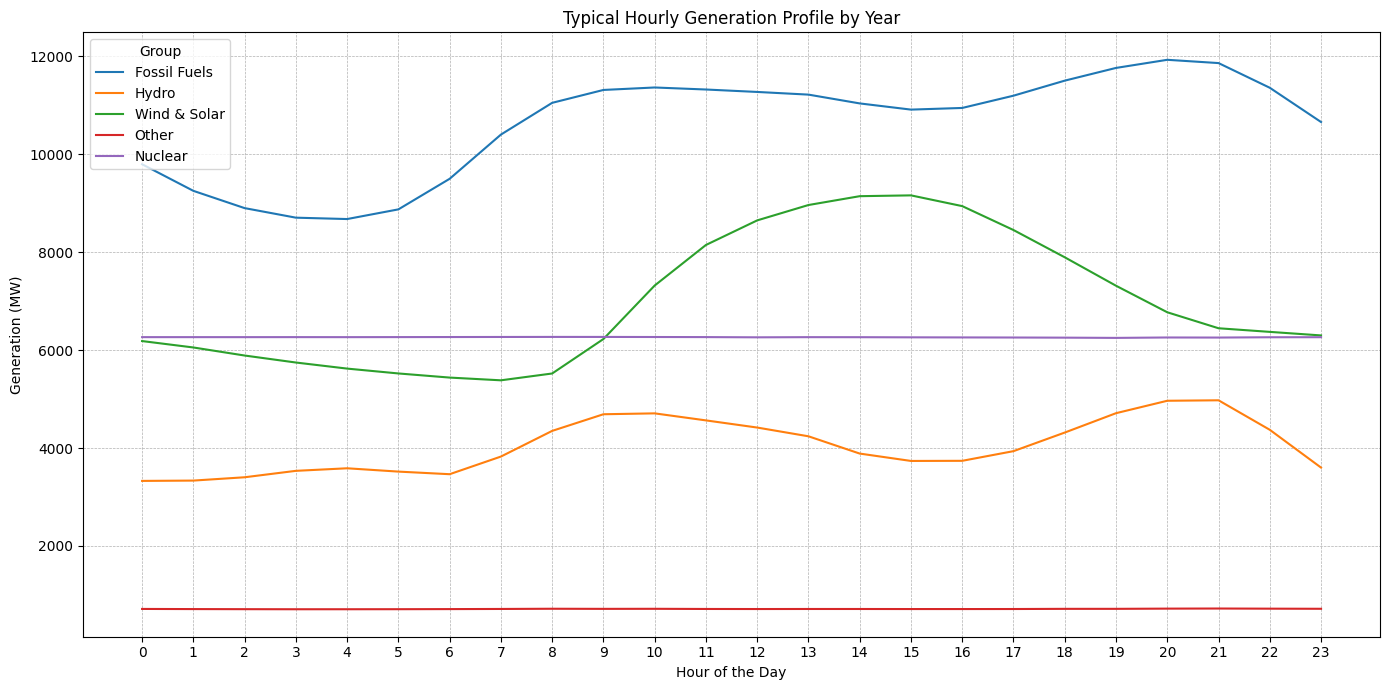

In [348]:
energy_sources_grouped_cols = energy_sources_grouped.columns

# Extract hour of the day and year directly dataframe
energy_sources_grouped['hour'] = energy_data.index.hour
energy_sources_grouped['year'] = energy_data.index.year

# Group by year and hour
hourly_means = energy_sources_grouped.groupby(['hour']).mean()

# Plot
plt.figure(figsize=(14, 7))

# For each year, plot the hourly profile
for group in energy_sources_grouped_cols.unique():
    plt.plot(hourly_means[group], label=group)

plt.title("Typical Hourly Generation Profile by Year")
plt.ylabel("Generation (MW)")
plt.xlabel("Hour of the Day")
plt.xticks(range(0, 24))
plt.legend(title="Group")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

/var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/ipykernel_81113/3986993842.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_solar_df['hour'] = wind_solar_df.index.hour
/var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/ipykernel_81113/3986993842.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_solar_df['year'] = wind_solar_df.index.year


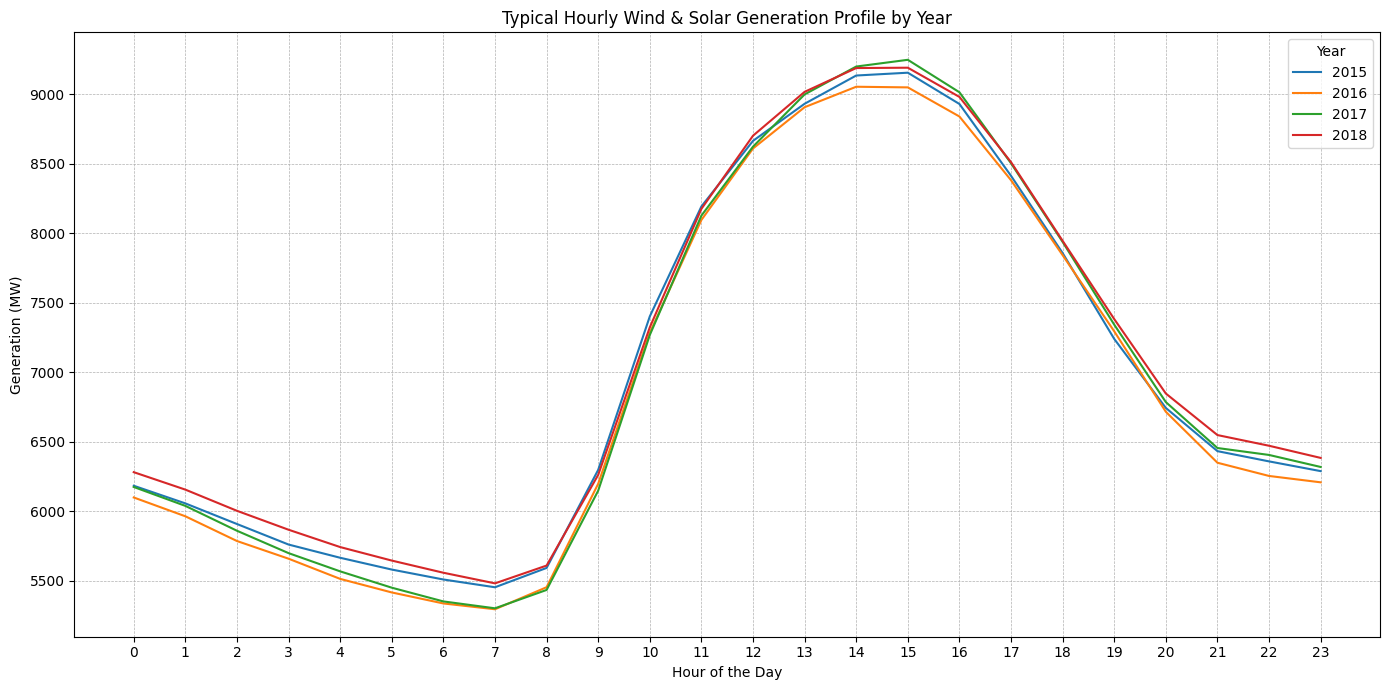

In [349]:
wind_solar_df = energy_sources_grouped[["Wind & Solar"]]

# Extract hour of the day and year directly into the wind_solar dataframe
wind_solar_df['hour'] = wind_solar_df.index.hour
wind_solar_df['year'] = wind_solar_df.index.year

# Group by year and hour
hourly_means = wind_solar_df.groupby(['year', 'hour']).mean()

# Plot
plt.figure(figsize=(14, 7))

# For each year, plot the hourly profile
for year in wind_solar_df['year'].unique():
    plt.plot(hourly_means.loc[year], label=year)

plt.title("Typical Hourly Wind & Solar Generation Profile by Year")
plt.ylabel("Generation (MW)")
plt.xlabel("Hour of the Day")
plt.xticks(range(0, 24))
plt.legend(title="Year")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


/var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/ipykernel_81113/1270748457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_df['hour'] = solar_df.index.hour
/var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/ipykernel_81113/1270748457.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_df['year'] = solar_df.index.year


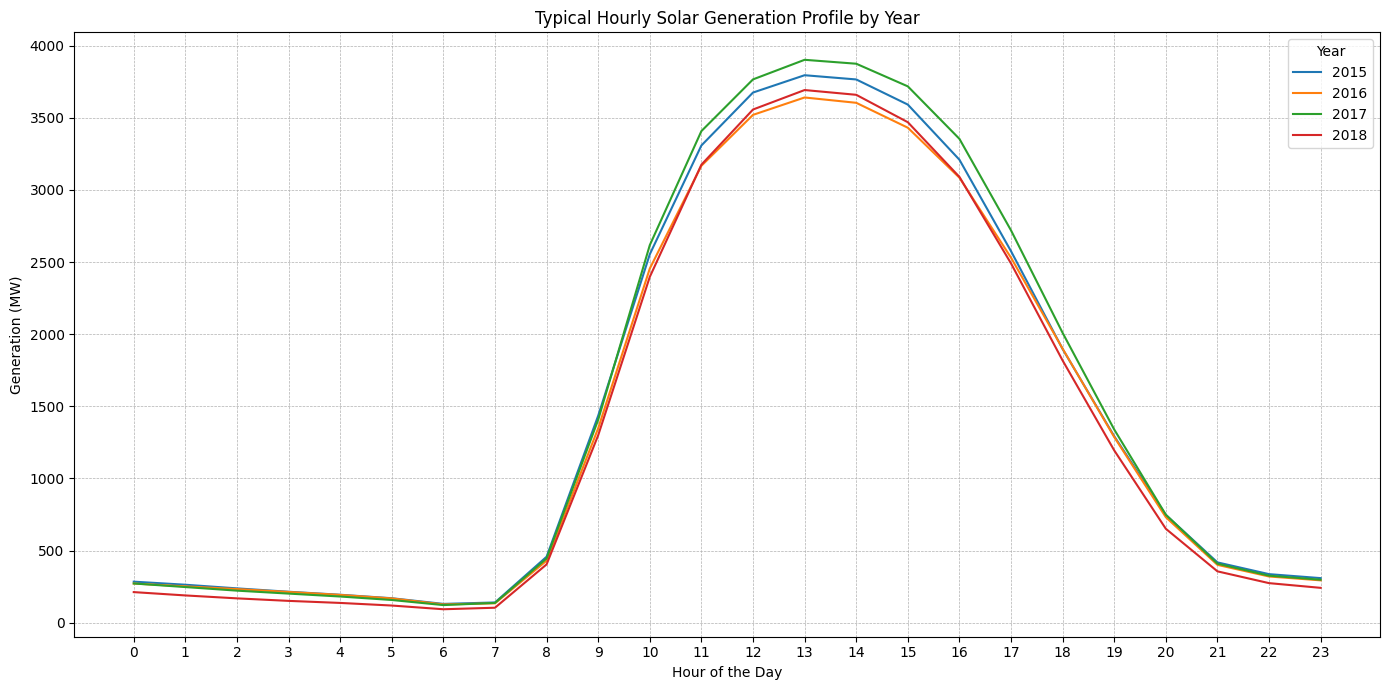

In [350]:
solar_df = energy_sources[["generation solar"]]

# Extract hour of the day and year directly into the wind_solar dataframe
solar_df['hour'] = solar_df.index.hour
solar_df['year'] = solar_df.index.year

# Group by year and hour
hourly_means = solar_df.groupby(['year', 'hour']).mean()

# Plot
plt.figure(figsize=(14, 7))

# For each year, plot the hourly profile
for year in solar_df['year'].unique():
    plt.plot(hourly_means.loc[year], label=year)

plt.title("Typical Hourly Solar Generation Profile by Year")
plt.ylabel("Generation (MW)")
plt.xlabel("Hour of the Day")
plt.xticks(range(0, 24))
plt.legend(title="Year")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

#### Notes and Observations
- Wind and solar make up a relatively small portion of the Spanish energy grid. Of the two, onshore wind generation is the larger portion
    - Wind and solar generation do not appear to increase year-over year. I was expecting some increase year-over-year as renewables become cheaper to make and install. This appears true when looking at solar alone as well. 
    - Despite solar prices going down, the grid does not appear to have had a significant increase in solar production
- Fossil fuels make up approx 25% of the grid make up
- Nuclear is a large portion, almost half of the energy grid make up
- Hydro makes up a larger portion than I was expecting
- Biomass and waste are small but important components to the energy grid make up

## Temporal Analysis
- Seasonal Patterns in energy_data
- Weekday vs. weekend

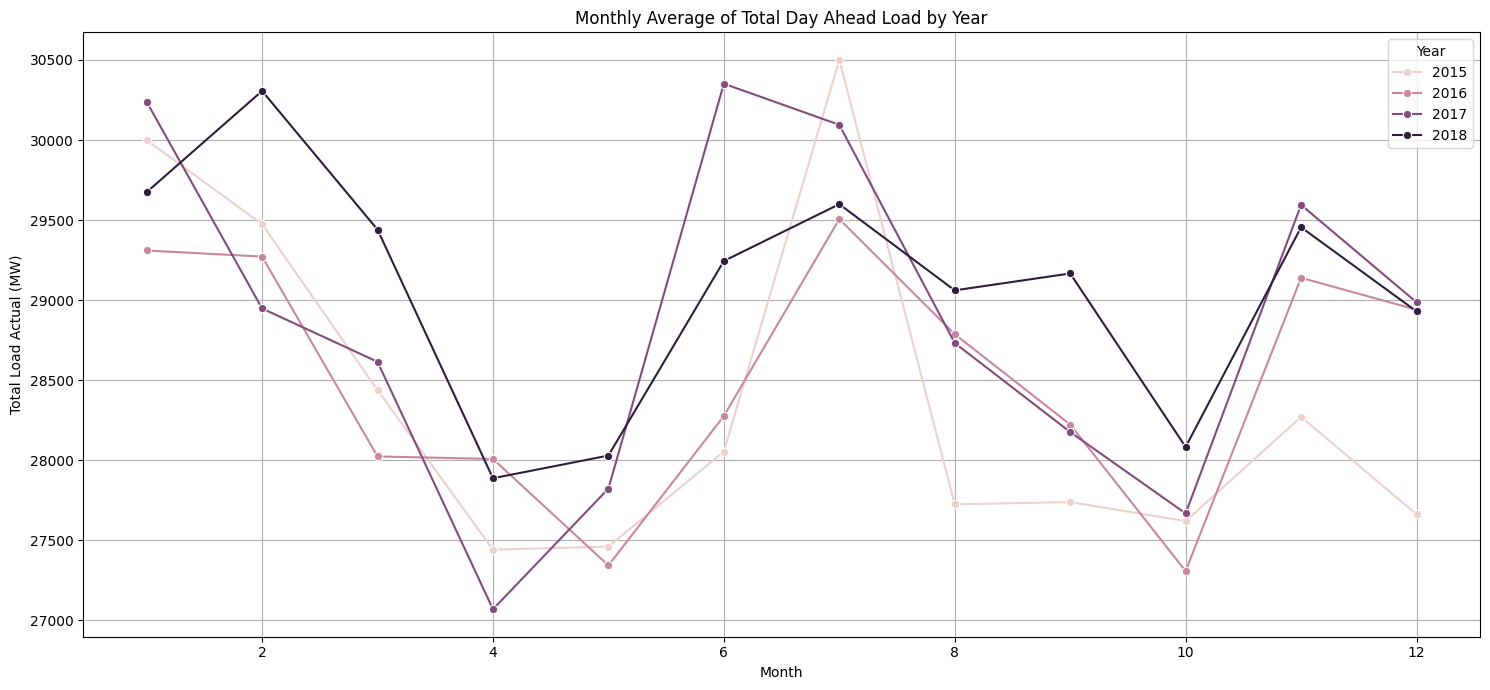

In [351]:
# Extract month and year from the datetime index
energy_data['Month'] = energy_data.index.month
energy_data['Year'] = energy_data.index.year

# Group by month and year and take the mean
monthly_avg = energy_data.groupby(['Year', 'Month'])['total load actual'].mean().reset_index()

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(x='Month', y='total load actual', hue='Year', data=monthly_avg, marker="o")
plt.title('Monthly Average of Total Day Ahead Load by Year')
plt.ylabel('Total Load Actual (MW)')
plt.xlabel('Month')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


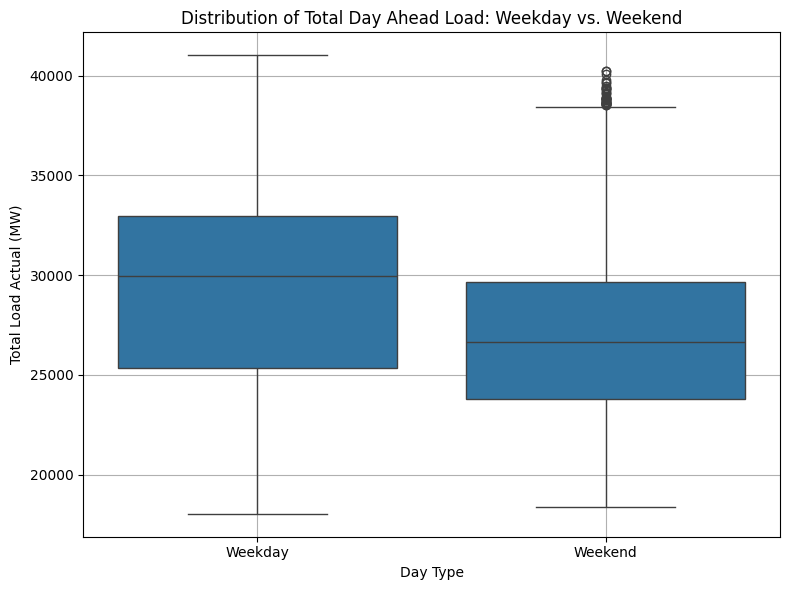

In [352]:
# Extract weekday from the datetime index (0 = Monday, 6 = Sunday)
energy_data['Weekday'] = energy_data.index.weekday

# Define a function to categorize days
def categorize_day(x):
    if x < 5:
        return 'Weekday'
    else:
        return 'Weekend'

energy_data['Day_Type'] = energy_data['Weekday'].apply(categorize_day)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Day_Type', y='total load actual', data=energy_data)
plt.title('Distribution of Total Day Ahead Load: Weekday vs. Weekend')
plt.ylabel('Total Load Actual (MW)')
plt.xlabel('Day Type')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Notes and Observations:
- Some seasonality to the energy data. There is a bit of a duck curve shape. For example, June, July and August has a total load peak, and so does January/February. This makes sense when you consider the weather is probably most extreme in these months, requiring additional load for heating or cooling. The annual peak sometimes occurs in sometimes June, sometimes July, and sometimes February. 
- Weekday load is generally higher than weekend load. There are some outliers in the weekend load that were higher than typically expected. 

## Load Distribution

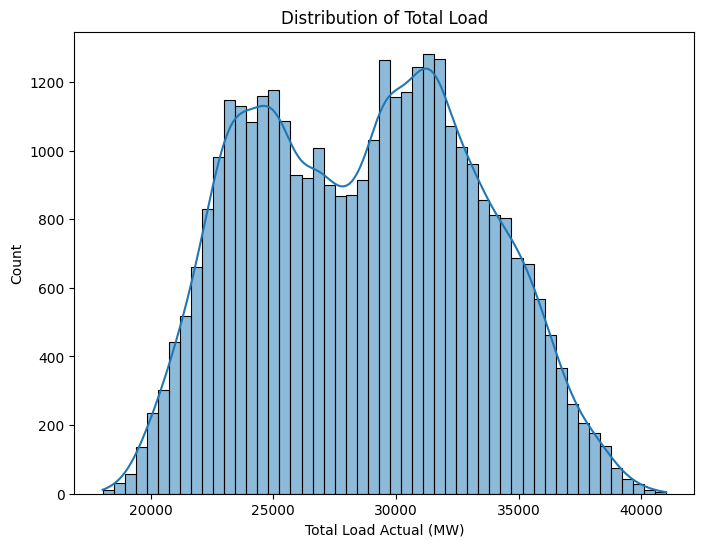

In [353]:
## Load Distribution
plt.figure(figsize=(8, 6))
sns.histplot(energy_data['total load actual'], kde=True)
plt.title('Distribution of Total Load')
plt.xlabel('Total Load Actual (MW)')
plt.show()

Notes And Observations:
- Peaks around 23000-25000 as well as 29000-32000 MW. Between the peaks is a significant dip

## Weather Data Exploration
- Temperature Distribution Across Cities

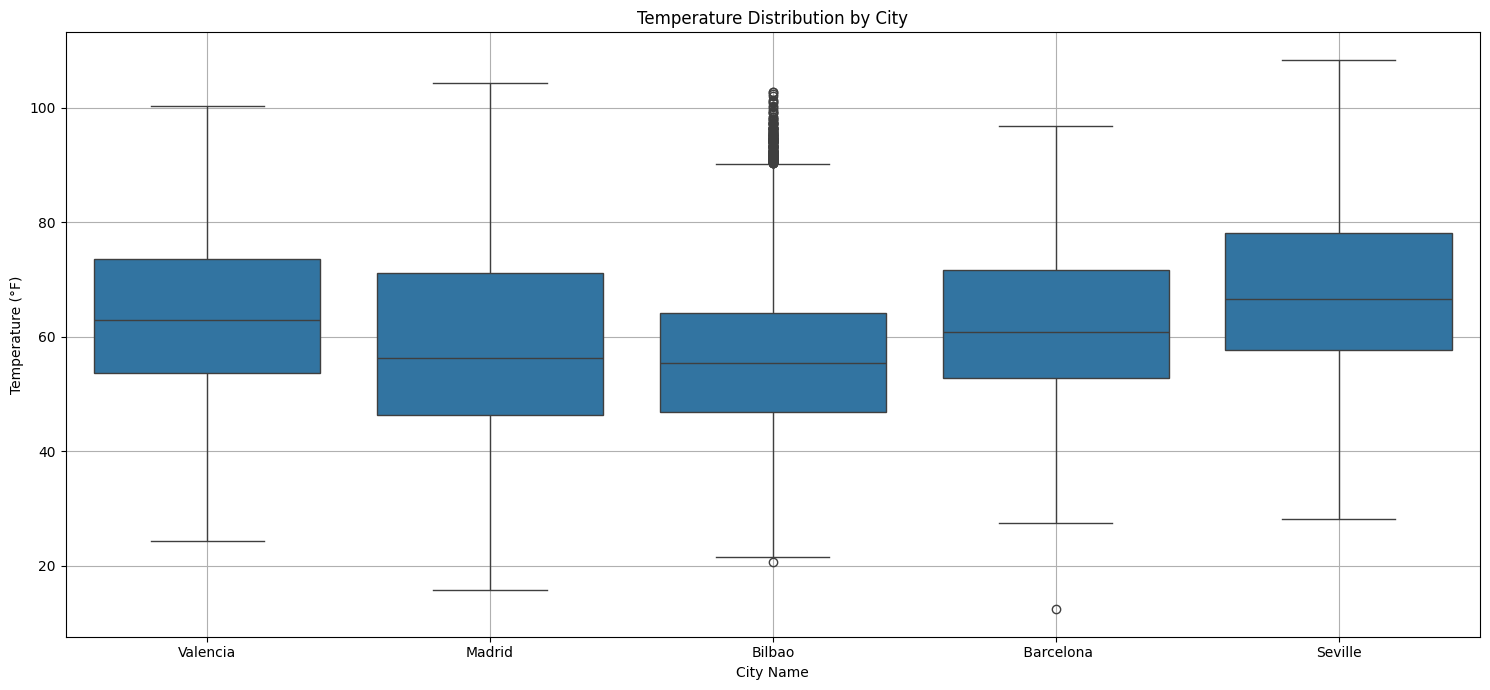

In [354]:
# Convert temperature from Kelvin to Fahrenheight
weather_features['temp_F'] = (weather_features['temp'] - 273.15) * 9/5 + 32


# Plot
plt.figure(figsize=(15, 7))
sns.boxplot(x='city_name', y='temp_F', data=weather_features)
plt.title('Temperature Distribution by City')
plt.ylabel('Temperature (°F)')
plt.xlabel('City Name')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Notes and Observations
- Seville tends to have warmer weather than the other cities
- Bilbao tends to have cooler weather than the other cities, though Madrid is very similar. Madrid's weather appears to have more of a spread than Bilbao.
- Overall, the weather is typically pleasant across all the cities, with most days hovering between 50-78°F depending on the city.
- All the cities have had some extreme weather events -- times where the temperature exceeded 100°F, and occasionally times where the temperature approached freezing. Madrid saw days where temperature dropped well below freezing.
- Madrid had the widest range of values

## Correlation Analysis: Load vs. Weather
- Specifically looking at the impact of temperature on load to begin with

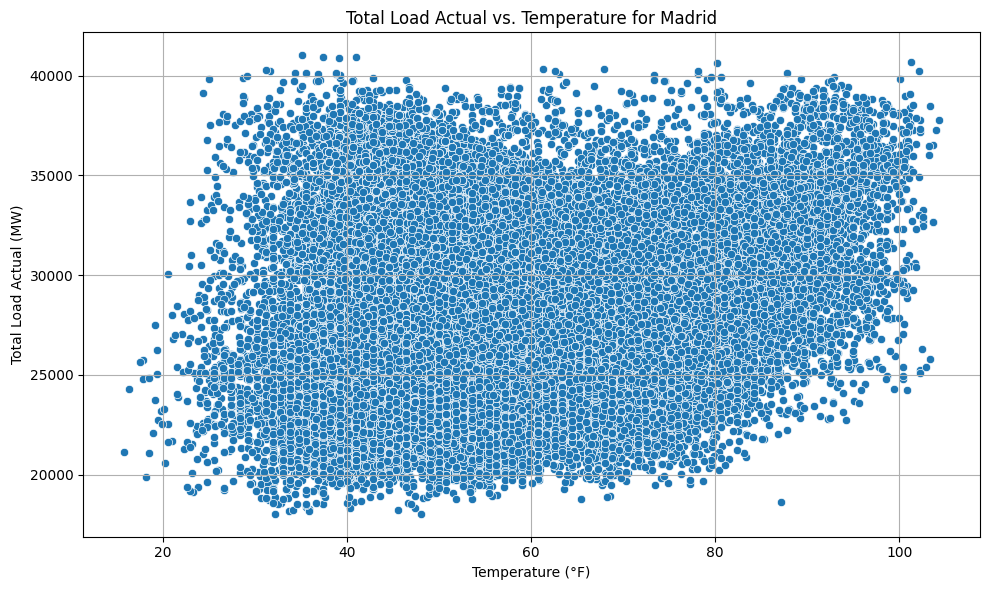

In [355]:
# Filtering data for a specific city, e.g., "Valencia"
# Note, Barcelona has a space at the start (ie " Barcelona") in the original data
# Madrid has the widest range of values so can be a good starting point
city = 'Madrid'

city_data = weather_features[weather_features['city_name'] == city]
merged_data = energy_data.merge(city_data, left_index=True, right_index=True)
merged_data = merged_data.reset_index(drop=True) # Reset the index as some duplicates may come up 


# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp_F', y='total load actual', data=merged_data)
plt.title(f'Total Load Actual vs. Temperature for {city}')
plt.ylabel('Total Load Actual (MW)')
plt.xlabel('Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Load at Extreme Temperatures

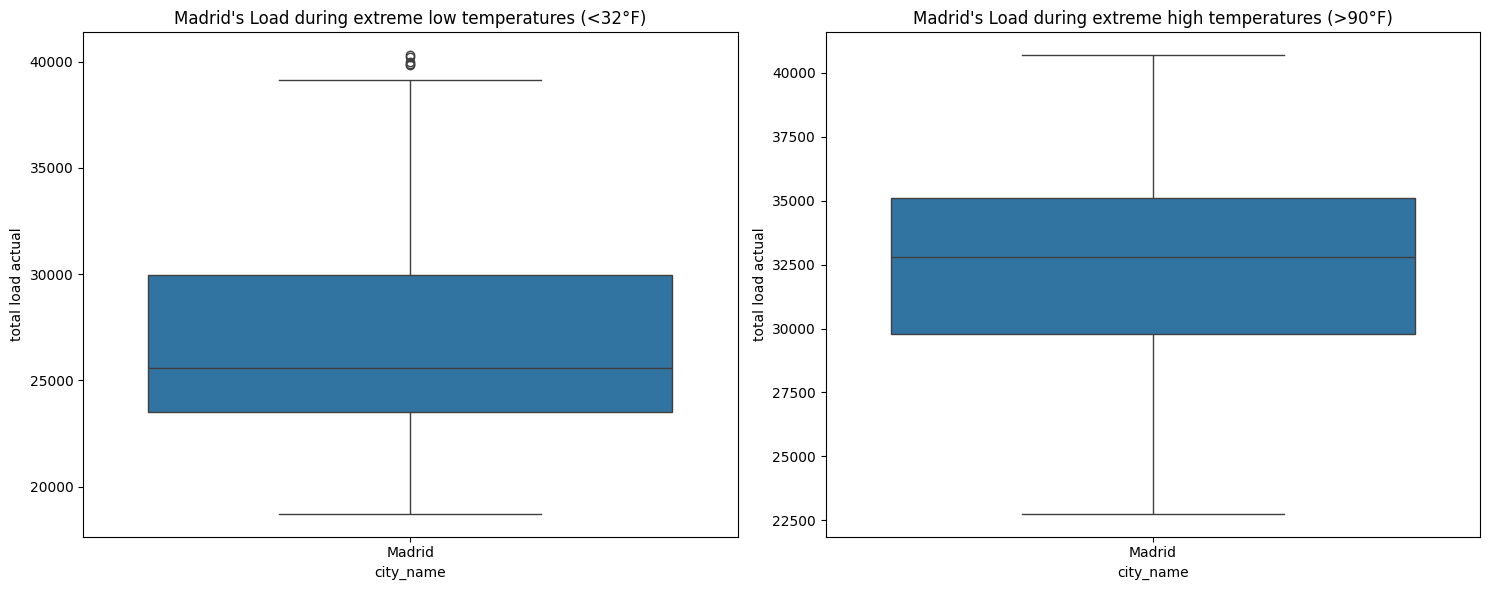

In [356]:
# Recall the following is based on the one city specified above.

# Extract data for extreme temperatures
extreme_low = merged_data[merged_data['temp_F'] < 32]
extreme_high = merged_data[merged_data['temp_F'] > 90]

# Plotting
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=extreme_low, x='city_name', y='total load actual')
plt.title(f"{city}'s Load during extreme low temperatures (<32°F)")

plt.subplot(1, 2, 2)
sns.boxplot(data=extreme_high, x='city_name', y='total load actual')
plt.title(f"{city}'s Load during extreme high temperatures (>90°F)")
plt.tight_layout()
plt.show()


### Correlation matrix

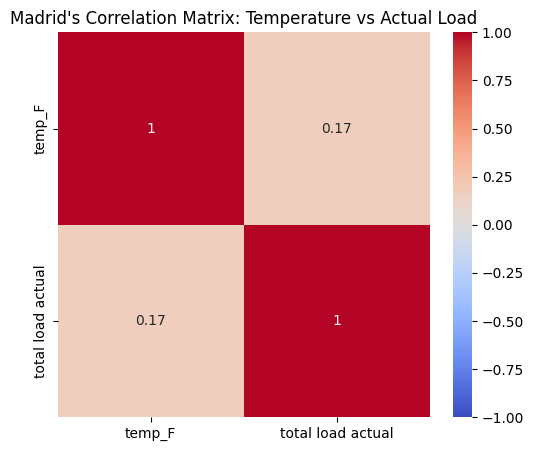

In [357]:
# Recall the following is based on the one city specified above.
correlation_matrix = merged_data[['temp_F', 'total load actual']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"{city}'s Correlation Matrix: Temperature vs Actual Load")
plt.show()


#### Notes and Observations
- Across all cities, there is a general trend in the load vs temperature data: it seems to me that there are two peaks, one around 30-40°F and one towards 85-100+°F, indicating the relationship is non-linear
- The true peak is generally at the higher temperatures (not the case for Bilbao)
- Something interesting happens when temperatures are really cold. Most of the time, there is a lower load, but some extreme cases had high energy loads.
- There is a weak, positive correlation between temp_F and total load actual:
    - Madrid has a correlation coefficient of 0.17 between temp_F and total load actual
    - Valencia has a correlation coefficient of 0.21 between temp_F and total load actual
    - Barcelona has a correlation coefficient of 0.17 between temp_F and total load actual
    - Bilbao has a correlation coefficient of 0.20 between temp_F and total load actual
    - Seville has a correlation coefficient of 0.20 between temp_F and total load actual

# Data Preprocessing

## Removing columns with zeroes or constant values

In [358]:
# Remove columns with constant values from energy_data
energy_data = energy_data.loc[:, (energy_data != energy_data.iloc[0]).any()]
# Remove columns with constant values from weather_features
weather_features = weather_features.loc[:, (weather_features != weather_features.iloc[0]).any()]

print(energy_data.columns, weather_features.columns)

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'Month', 'Year',
       'Weekday', 'Day_Type'],
      dtype='object') Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rai

## Preliminary Feature Selection

Features to start with: 
- temp_F
- temp_extreme_cold: Create a binary column (0 or 1) where 1 represents days with temp_F < 32.
- temp_extreme_hot: Create a binary column (0 or 1) where 1 represents days with temp_F > 90.
- day_type: a binary column, 0 for weekend, 1 for weekday
- season: derive season based on month (Spring: March, April, May; Summer: June, July, August; Fall: September, October, November; Winter: December, January, February). Then, one-hot encode the season column.
- hour
- previous_day_load: the previous day's load. Shifts the total load actual down by one.

*Note that city is inside the temperature column's names, so one-hot coding will naturally occur when selecting temperature features for each city

The target variable is total load actual.

#### Dealing with Duplicated observations in weather_features
There are some observations in weather_features which are duplicated. From first glance, perhaps the only differences are weather_main and weather_description. The following investigates this

In [359]:
# Identify duplicates in dt_iso and city_name columns
duplicates = weather_features_reset[weather_features_reset.duplicated(subset=['dt_iso', 'city_name'], keep=False)]

# Display duplicated rows for manual inspection
print(duplicates.sort_values(by=['dt_iso', 'city_name']).head())

Empty DataFrame
Columns: [dt_iso, city_name, temp, temp_min, temp_max, pressure, humidity, wind_speed, wind_deg, rain_1h, rain_3h, snow_3h, clouds_all, weather_id, weather_main, weather_description, weather_icon, temp_F]
Index: []


In [360]:
# Check that temp_F is identical (or nearly identical) between duplicated observations

# Define a threshold
threshold = 0.1

# Function to check if temp_F values in a group are not identical
def non_identical_temp(group):
    return group['temp_F'].max() - group['temp_F'].min() > threshold

# Use groupby and filter to find the non-identical groups
non_identical_rows = duplicates.groupby(['dt_iso', 'city_name']).filter(non_identical_temp)

# Display the results
print(non_identical_rows)


Empty DataFrame
Columns: [dt_iso, city_name, temp, temp_min, temp_max, pressure, humidity, wind_speed, wind_deg, rain_1h, rain_3h, snow_3h, clouds_all, weather_id, weather_main, weather_description, weather_icon, temp_F]
Index: []


### Merging datasets; setting up features

In [384]:
# Resetting the index for both dataframes
weather_features_reset = weather_features.reset_index()
energy_data_reset = energy_data.reset_index()

# Dropping duplicate rows based on 'dt_iso' and 'city_name' and keeping the first occurrence
weather_features_reset = weather_features_reset.drop_duplicates(subset=['dt_iso', 'city_name'], keep='first')

# Pivoting the weather data
weather_pivot = weather_features_reset.pivot(index='dt_iso', columns='city_name', values='temp_F')

# Column names generated for weather_pivot
weather_pivot.columns = [f'{city}_temp_F' for city in weather_pivot.columns]

# Merging the energy data with the pivoted weather data
energy_weather_merged = pd.merge(energy_data_reset, weather_pivot, left_on='time', right_on='dt_iso', how='left')

# Generating extreme cold/hot columns
extreme_cold_threshold = 32
extreme_hot_threshold = 90

cities = ['Madrid', 'Seville', ' Barcelona', 'Bilbao', 'Valencia']

energy_weather_merged['temp_extreme_cold'] = energy_weather_merged[[f'{city}_temp_F' for city in cities]].apply(lambda row: sum(1 for temp in row if temp < extreme_cold_threshold)/len(cities), axis=1)
energy_weather_merged['temp_extreme_hot'] = energy_weather_merged[[f'{city}_temp_F' for city in cities]].apply(lambda row: sum(1 for temp in row if temp > extreme_hot_threshold)/len(cities), axis=1)

# Historical Load
energy_weather_merged.set_index('time', inplace=True)
energy_weather_merged['previous_day_load'] = energy_weather_merged['total load actual'].shift(freq='1D')

# Drop NaN values after shifts
energy_weather_merged.dropna(inplace=True)

# Derive day_type
energy_weather_merged['day_type'] = energy_weather_merged.index.weekday
energy_weather_merged['day_type'] = energy_weather_merged['day_type'].apply(lambda x: 0 if x >= 5 else 1)

# Derive season
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

energy_weather_merged['season'] = energy_weather_merged.index.month
energy_weather_merged['season'] = energy_weather_merged['season'].apply(get_season)

# One-hot encode season
season_dummies = pd.get_dummies(energy_weather_merged['season'], prefix='season')

# Derive hour
energy_weather_merged['hour'] = energy_weather_merged.index.hour

# Since we will later scale the feature matrix, which will not make sense for the 'hour' column,
# we use sin(2pi*x) and cos(2pi*x) to transform hour and indicate the cyclical nature of the hour feature
energy_weather_merged['hour_sin'] = np.sin(2 * np.pi * energy_weather_merged['hour'] / 24)
energy_weather_merged['hour_cos'] = np.cos(2 * np.pi * energy_weather_merged['hour'] / 24)


energy_weather_merged

generation biomass  \
time                                            
2015-01-02 02:00:00+01:00               358.0   
2015-01-02 05:00:00+01:00               354.0   
2015-01-02 08:00:00+01:00               359.0   
2015-01-02 12:00:00+01:00               376.0   
2015-01-02 14:00:00+01:00               383.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-02 02:00:00+01:00                                   0.0   
2015-01-02 05:00:00+01:00                                   0.0   
2015-01-02 08:00:00+01:00                                   0.0   
2015-01-02 12:00:00+01:00                                   0.0   
2015-01-02 14:00:00+01:00                                   0.0   
...                                                         ...   
2018-12-31 19:00:00+01:00                                   0.0   
2018-12-31 20:00:00+01:00                                   0.0   
2018-12-31 21:00:00+01:00                                   0.0   
2018-12-31 22:00:00+01:00                                   0.0   
2018-12-31 23:00:00+01:00                                   0.0   

                           generation fossil coal-derived gas  \
time                                                            
2015-01-02 02:00:00+01:00                                 0.0   
2015-01-02 05:00:00+01:00                                 0.0   
2015-01-02 08:00:00+01:00                                 0.0   
2015-01-02 12:00:00+01:00                                 0.0   
2015-01-02 14:00:00+01:00                                 0.0   
...                                                       ...   
2018-12-31 19:00:00+01:00                                 0.0   
2018-12-31 20:00:00+01:00                                 0.0   
2018-12-31 21:00:00+01:00                                 0.0   
2018-12-31 22:00:00+01:00                                 0.0   
2018-12-31 23:00:00+01:00                                 0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-02 02:00:00+01:00                 2772.0                       1023.0   
2015-01-02 05:00:00+01:00                 2889.0                       1120.0   
2015-01-02 08:00:00+01:00                 2869.0                       1098.0   
2015-01-02 12:00:00+01:00                 2606.0                       1336.0   
2015-01-02 14:00:00+01:00                 2729.0                       1354.0   
...                                          ...                          ...   
2018-12-31 19:00:00+01:00                 7634.0                       2628.0   
2018-12-31 20:00:00+01:00                 7241.0                       2566.0   
2018-12-31 21:00:00+01:00                 7025.0                       2422.0   
2018-12-31 22:00:00+01:00                 6562.0                       2293.0   
2018-12-31 23:00:00+01:00                 6926.0                       2166.0   

                           generation fossil oil  generation fossil oil shale  \
time                                                                            
2015-01-02 02:00:00+01:00                  189.0                          0.0   
2015-01-02 05:00:00+01:00                  190.0                          0.0   
2015-01-02 08:00:00+01:00                  196.0                          0.0   
2015-01-02 12:00:00+01:00                  197.0                          0.0   
2015-01-02 14:00:00+01:00                  195.0                          0.0   
...                                          ...  

In [385]:
# Standard scaling on non-binary values
# A commonly used method is Min-Max Scaling (Normalization) which scales the data between 0 and 1. 
# Another method is the Standard Scaler (Standardization) which scales the data based on mean and standard deviation.
# We will use Standard Scalar method here


# Create a dedicated feature matrix
features = energy_weather_merged.filter(like='_temp_F').columns.tolist() + ['previous_day_load', 'temp_extreme_cold', 'temp_extreme_hot', 'day_type', 'hour_sin', 'hour_cos']
feature_matrix = pd.concat([energy_weather_merged[features], season_dummies], axis=1)

# Scaling using StandardScaler
scaler = StandardScaler()
cols_to_scale = ['previous_day_load'] + feature_matrix.filter(like='_temp_F').columns.tolist()
feature_matrix[cols_to_scale] = scaler.fit_transform(feature_matrix[cols_to_scale])

feature_matrix


Barcelona_temp_F  Bilbao_temp_F  Madrid_temp_F  \
time                                                                         
2015-01-02 02:00:00+01:00          -1.180208      -2.043273      -2.365049   
2015-01-02 05:00:00+01:00          -1.240879      -2.271895      -2.417432   
2015-01-02 08:00:00+01:00          -1.085814      -2.203416      -2.102491   
2015-01-02 12:00:00+01:00          -0.662590      -0.827232      -1.322238   
2015-01-02 14:00:00+01:00          -0.562555      -0.259549      -0.455543   
...                                      ...            ...            ...   
2018-12-31 19:00:00+01:00          -0.846518      -0.781925      -0.518107   
2018-12-31 20:00:00+01:00          -1.065934      -0.996398      -0.888119   
2018-12-31 21:00:00+01:00          -1.139564      -1.389846      -1.100016   
2018-12-31 22:00:00+01:00          -1.288296      -1.471198      -1.269963   
2018-12-31 23:00:00+01:00          -1.435556      -1.619110      -1.422701   

                           Seville_temp_F  Valencia_temp_F  previous_day_load  \
time                                                                            
2015-01-02 02:00:00+01:00       -2.131562        -2.823926          -1.333993   
2015-01-02 05:00:00+01:00       -2.192324        -2.877753          -1.953162   
2015-01-02 08:00:00+01:00       -1.958010        -2.300128          -1.911797   
2015-01-02 12:00:00+01:00       -0.942400        -0.648621          -1.027801   
2015-01-02 14:00:00+01:00       -0.878807        -0.512412          -0.909833   
...                                   ...              ...                ...   
2018-12-31 19:00:00+01:00       -0.703469        -0.740974           0.085783   
2018-12-31 20:00:00+01:00       -0.953005        -1.088689           0.265471   
2018-12-31 21:00:00+01:00       -1.029113        -1.294536           0.306399   
2018-12-31 22:00:00+01:00       -1.153881        -1.505947           0.069150   
2018-12-31 23:00:00+01:00       -1.176339        -1.645033          -0.414761   

                           temp_extreme_cold  temp_extreme_hot  day_type  \
time                                                                       
2015-01-02 02:00:00+01:00                0.6               0.0         1   
2015-01-02 05:00:00+01:00                0.6               0.0         1   
2015-01-02 08:00:00+01:00                0.4               0.0         1   
2015-01-02 12:00:00+01:00                0.0               0.0         1   
2015-01-02 14:00:00+01:00                0.0               0.0         1   
...                                      ...               ...       ...   
2018-12-31 19:00:00+01:00                0.0               0.0         1   
2018-12-31 20:00:00+01:00                0.0               0.0         1   
2018-12-31 21:00:00+01:00                0.0               0.0         1   
2018-12-31 22:00:00+01:00                0.0               0.0         1   
2018-12-31 23:00:00+01:00                0.0               0.0         1   

                               hour_sin  hour_cos  season_Fall  season_Spring  \
time                                                                            
2015-01-02 02:00:00+01:00  5.000000e-01  0.866025        False          False   
2015-01-02 05:00:00+01:00  9.659258e-01  0.258819        False          False   
2015-01-02 08:00:00+01:00  8.660254e-01 -0.500000        False          False   
2015-01-02 12:00:00+01:00  1.224647e-16 -1.000000        False          False   
2015-01-02 14:00:00+01:00 -5.000000e-01 -0.866025        False          False   
...                                 ...       ...          ...            ...   
2018-12-31 19:00:00+01:00 -9.659258e-01  0.258819        False          False   
2018-12-31 20:00:00+01:00 -8.660254e-01  0.500000        False          False   
2018-12-31 21:00:00+01:00 -7.071068e-01  0.707107        False          False   
2018-12-31 22:00:00+01:00 -5.000000e-01  0.866025        False          False  

In [383]:
feature_matrix.describe()

Barcelona_temp_F  Bilbao_temp_F  Madrid_temp_F  Seville_temp_F  \
count       3.089900e+04   3.089900e+04   3.089900e+04    3.089900e+04   
mean        1.250964e-16   2.501927e-16  -6.622749e-17    2.354755e-16   
std         1.000016e+00   1.000016e+00   1.000016e+00    1.000016e+00   
min        -2.831577e+00  -2.913345e+00  -2.607816e+00   -2.788340e+00   
25%        -7.699427e-01  -7.464259e-01  -7.762548e-01   -7.309183e-01   
50%        -1.072746e-01  -4.088287e-02  -1.566993e-01   -9.959303e-02   
75%         7.762829e-01   6.794514e-01   7.252532e-01    7.089025e-01   
max         2.837917e+00   3.829989e+00   2.684006e+00    2.770067e+00   

       Valencia_temp_F  previous_day_load  temp_extreme_cold  \
count     3.089900e+04       3.089900e+04       30899.000000   
mean      2.943444e-17       1.628092e-16           0.007411   
std       1.000016e+00       1.000016e+00           0.046782   
min      -3.078919e+00      -2.361127e+00           0.000000   
25%      -7.854469e-01      -8.492076e-01           0.000000   
50%      -5.201157e-02       5.514226e-02           0.000000   
75%       7.624305e-01       7.634986e-01           0.000000   
max       2.807110e+00       2.667076e+00           0.800000   

       temp_extreme_hot      day_type          hour  
count      30899.000000  30899.000000  3.089900e+04  
mean           0.031347      0.713000  6.829709e-17  
std            0.106710      0.452369  1.000016e+00  
min            0.000000      0.000000 -1.690615e+00  
25%            0.000000      0.000000 -8.204187e-01  
50%            0.000000      1.000000  4.977739e-02  
75%            0.000000      1.000000  9.199735e-01  
max            1.000000      1.000000  1.645137e+00

In [388]:
# Target vector
y = energy_weather_merged['total load actual']

In [389]:
# Benchmarking vector
benchmark = energy_weather_merged['total load forecast']

#### Notes & Observations
- All values in the feature matrix are scaled, either between 0 and 1 for temp_extreme_cold, temp_extreme_hot, and day_type, or scaled using StandardScaler, meaning that they have a mean of 0 and standard deviation of +/- 1.
- For Random Forest, the scaling is less relevant but can still be used
- For KNN, scaling is critical as it is a distance-based model
- ARIMA is a time series forecasting model. It doesn't require feature scaling like KNN, but it does often require stationarity, which means that the mean, variance, and autocorrelation structure do not change over time. This is a different kind of preprocessing.
- Note technically we have redundancy with the season columns (ie we have a redundant column which can be implied by others-- if summer, winter, and fall are false then spring must be true). This could lead to multicollinearity (meaning one can be linearly predicted from the others with a substantial degree of accuracy), however this is not a concern for KNN or Random forest. We may want to drop one of these columns later

# Model Selection Training & Verification
We'll start with KNN as that is one of the simplest time-series forecasting models we could use and then work to a random forest model

In [423]:
# Since this is timeseries forecasting, the train_test_split() function could impose data leakage, where future time stamps are being 
# used to predict the future

train_size = int(len(feature_matrix) * 0.8)
X_train, X_test = feature_matrix[:train_size], feature_matrix[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [480]:
# Initialize TimeSeriesSplit Cross Validation with 5 splits
tscv = TimeSeriesSplit(n_splits=5)


## KNN

Small k: When k is small (e.g., 1 or 2), the model is more sensitive to noise in the data. A small k means that the prediction is based on a very limited number of nearest neighbors. As a result, random variations or anomalies in the data can heavily influence the predictions, making the model less stable and more sensitive to outliers.

Large k: As k increases, the predictions become based on a larger number of neighbors, which tends to smooth out the predictions, making them less sensitive to any individual observation. This can help in reducing variance and can lead to better generalization on the test set. However, if k is set too large, then the model might become too generalized and might not capture the underlying patterns in the data effectively.

In [481]:

# List of 'k' values to test
k_values = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45]
rmse_values = []

for k in k_values:
    # Temporary list to store RMSE for each cross-validation fold
    temp_rmse = []

    # Initialize the model with the current 'k' value
    knn = KNeighborsRegressor(n_neighbors=k)

    for train_idx, val_idx in tscv.split(X_train):
        # Split the data into training and validation sets
        CV_X_train, CV_X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        CV_y_train, CV_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model on the training data
        knn.fit(CV_X_train, CV_y_train)

        # Predict on the validation set
        y_pred = knn.predict(CV_X_val)

        # Calculate the RMSE for the current fold and append to temporary list
        fold_rmse = mean_squared_error(CV_y_val, y_pred, squared=False)
        temp_rmse.append(fold_rmse)

    # Calculate the average RMSE for this value of 'k' and append to the main RMSE list
    avg_knn_rmse = np.mean(temp_rmse)
    rmse_values.append(avg_knn_rmse)

    print(f"n_neighbors: {k} -> Average RMSE: {round(avg_knn_rmse,2)}")


n_neighbors: 3 -> Average RMSE: 3107.96
n_neighbors: 5 -> Average RMSE: 2940.95
n_neighbors: 10 -> Average RMSE: 2791.64
n_neighbors: 15 -> Average RMSE: 2738.89
n_neighbors: 20 -> Average RMSE: 2718.07
n_neighbors: 25 -> Average RMSE: 2708.37
n_neighbors: 30 -> Average RMSE: 2702.34
n_neighbors: 35 -> Average RMSE: 2697.68
n_neighbors: 40 -> Average RMSE: 2697.39
n_neighbors: 45 -> Average RMSE: 2699.18


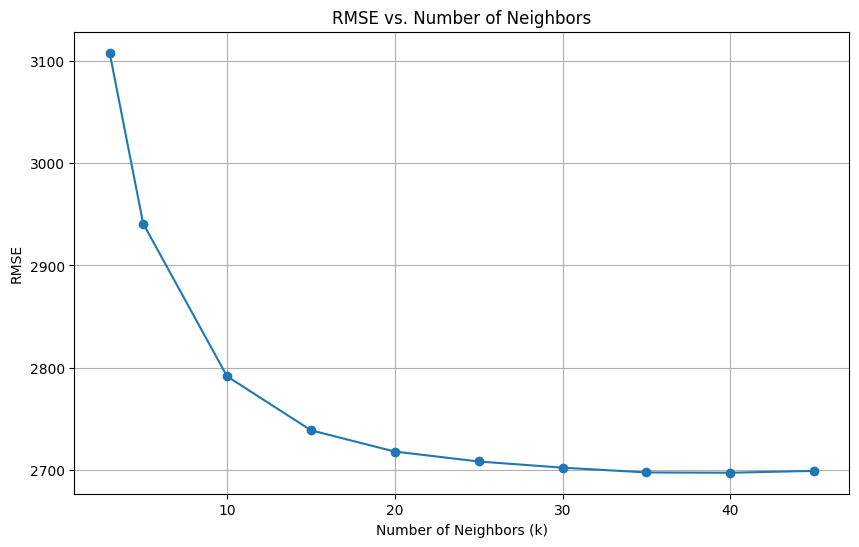

In [472]:
# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Number of Neighbors")
plt.grid(True)
plt.show()



At number of neighbors = 35, the RMSE plateaus, suggesting that increasing k further will not significantly improve the model's performance

In [474]:
# Calculate the final MAE and RMSE 
# Initialize the model with the current 'k' value found from previous experiments
knn = KNeighborsRegressor(n_neighbors=35)

# Train the model on the entire training set
knn.fit(X_train, y_train)

# Predict future values on the entire test set
knn_y_pred = knn.predict(X_test)

# Calculate RMSE for the current 'k' value
knn_rmse = mean_squared_error(y_test, knn_y_pred, squared=False)

knn_mae = mean_absolute_error(y_test, knn_y_pred)
knn_rmse = mean_squared_error(y_test, knn_y_pred, squared=False)

print(f"MAE: {round(knn_mae,2)}")
print(f"RMSE: {round(knn_rmse,2)}")

MAE: 1801.78
RMSE: 2569.91


## Random Forest

In [494]:
n_trees = [50, 100, 150, 200, 250, 300]
avg_rmse_values = []

for trees in n_trees:
    rf_rmse_values = []
    # Initialize Random Forest model
    rf = RandomForestRegressor(n_estimators=trees, random_state=42)
    
    # Using TimeSeriesSplit Cross Validation to get training and validation data
    for train_index, val_index in tscv.split(X_train):
        CV_X_train, CV_X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        CV_y_train, CV_y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        rf.fit(CV_X_train, CV_y_train)
        rf_y_pred = rf.predict(CV_X_val)
        
        rf_rmse = mean_squared_error(CV_y_val, rf_y_pred, squared=False)
        rf_rmse_values.append(rf_rmse)
    
    avg_rf_rmse = np.mean(rf_rmse_values)  
    avg_rmse_values.append(avg_rf_rmse)
    print(f"n_estimators: {trees} -> Average RMSE across CV: {round(avg_rf_rmse,2)}")


n_estimators: 50 -> Average RMSE across CV: 2692.63
n_estimators: 100 -> Average RMSE across CV: 2677.52
n_estimators: 150 -> Average RMSE across CV: 2669.67
n_estimators: 200 -> Average RMSE across CV: 2668.2
n_estimators: 250 -> Average RMSE across CV: 2667.34
n_estimators: 300 -> Average RMSE across CV: 2666.76


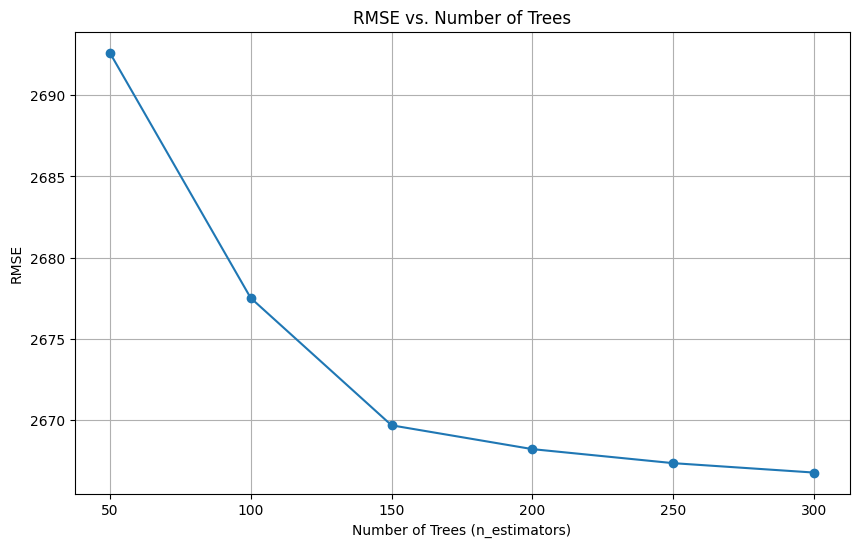

In [495]:
# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(n_trees, avg_rmse_values, marker='o', linestyle='-')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Number of Trees")
plt.grid(True)
plt.show()

At number of trees = 150, the RMSE plateaus, suggesting that increasing n_estimators further will not significantly improve the model's performance

In [496]:
# Final RF model
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)

print(f"Random Forest MAE: {round(rf_mae,2)}")
print(f"Random Forest RMSE: {round(rf_rmse,2)}")


Random Forest MAE: 1810.71
Random Forest RMSE: 2596.96


/var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/ipykernel_81113/2340596872.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis")


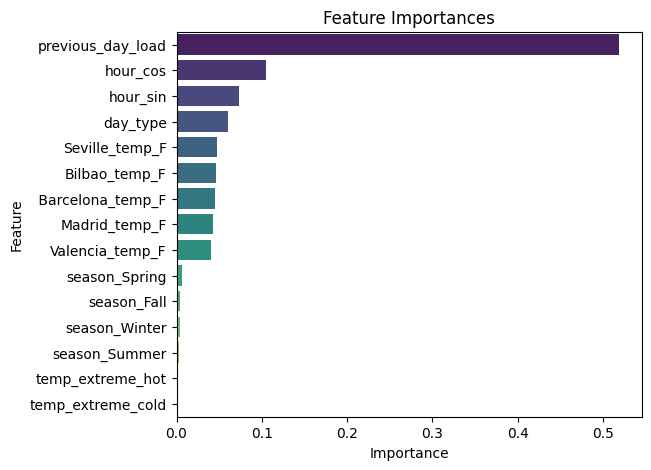

[('previous_day_load', 0.5191701546668138),
 ('hour_cos', 0.1054168252933068),
 ('hour_sin', 0.07375533815998057),
 ('day_type', 0.060533204092406465),
 ('Seville_temp_F', 0.047822934703185264),
 ('Bilbao_temp_F', 0.04668932070690418),
 (' Barcelona_temp_F', 0.044688246419455194),
 ('Madrid_temp_F', 0.043126243761121064),
 ('Valencia_temp_F', 0.03987198796139846),
 ('season_Spring', 0.005999556998600798),
 ('season_Fall', 0.004488595364824002),
 ('season_Winter', 0.004358700515548997),
 ('season_Summer', 0.002401355839218741),
 ('temp_extreme_hot', 0.001015450803020389),
 ('temp_extreme_cold', 0.0006620847142153488)]

In [519]:
# Extract feature importances
importances = rf.feature_importances_

# Pair them with their respective feature names
feature_importance_pairs = list(zip(X_train.columns, importances))

# 3. Sort the feature importances in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Splitting into separate lists for easier plotting
features, importances = zip(*sorted_feature_importance_pairs)

# Plotting
plt.figure(figsize=(6, 5))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

sorted_feature_importance_pairs

# Benchmarking Against TSO

In [475]:
# Describe the benchmark so we know what we are comparing against
benchmark.describe()

count    30899.000000
mean     28830.037445
std       4585.565902
min      18105.000000
25%      24925.500000
50%      29071.000000
75%      32368.500000
max      41390.000000
Name: total load forecast, dtype: float64

In [476]:
# Match the benchmark indices with the y_test indices
benchmark_test = benchmark[y_test.index]

# Calculate the benchmark rmse relative to y_test
benchmark_rmse = np.sqrt(mean_squared_error(y_test, benchmark_test))

## KNN

In [479]:
print(f"My KNN Model RMSE: {round(knn_rmse,2)}")
print(f"Benchmark RMSE: {round(benchmark_rmse,2)}\n")

print(f"My kNN model's average error (RMSE) is around {round(knn_rmse/benchmark.describe()['mean']*100,2)}% of the mean load value.")
print(f"The benchmark's average error is around {round(benchmark_rmse/benchmark.describe()['mean']*100,2)}% of the mean load value.")

My KNN Model RMSE: 2569.91
Benchmark RMSE: 372.46

My kNN model's average error (RMSE) is around 8.91% of the mean load value.
The benchmark's average error is around 1.29% of the mean load value.


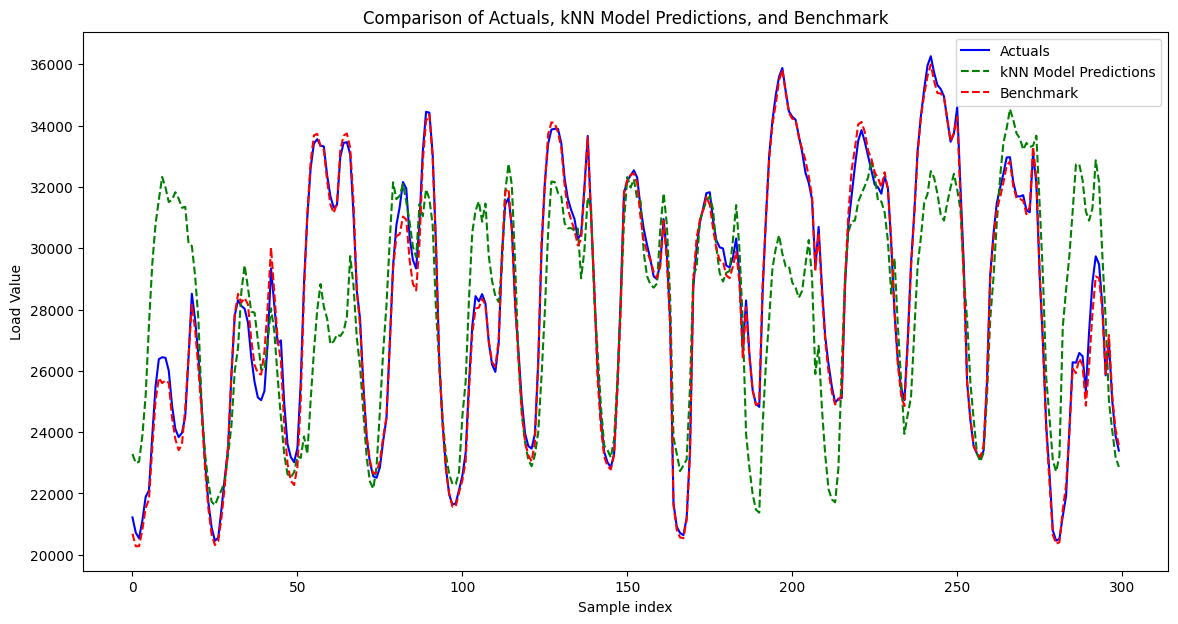

In [478]:
# Sample for visualization (e.g., 200 points)
sample_size = 300
indices = range(sample_size)

plt.figure(figsize=(14, 7))

# Plot actuals
plt.plot(indices, y_test[:sample_size], label="Actuals", color="blue")

# Plot model predictions
plt.plot(indices, knn_y_pred[:sample_size], label="kNN Model Predictions", color="green", linestyle="--")

# Plot benchmark
plt.plot(indices, benchmark_test[:sample_size], label="Benchmark", color="red", linestyle="--")

plt.title("Comparison of Actuals, kNN Model Predictions, and Benchmark")
plt.xlabel("Sample index")
plt.ylabel("Load Value")
plt.legend()
plt.show()


Upon visual inspection of the model's predictions, the KNN model seems to capture the overall trend and shape of the load effectively. However, it struggles with the magnitude, both underpredicting and overpredicting the peak load values.

## Random Forest

In [497]:
print(f"My Random Forest Model RMSE: {round(rf_rmse,2)}")
print(f"Benchmark RMSE: {round(benchmark_rmse,2)}\n")

print(f"My Random Forest model's average error (RMSE) is around {round(rf_rmse/benchmark.describe()['mean']*100,2)}% of the mean load value.")
print(f"The benchmark's average error is around {round(benchmark_rmse/benchmark.describe()['mean']*100,2)}% of the mean load value.")

My Random Forest Model RMSE: 2596.96
Benchmark RMSE: 372.46

My Random Forest model's average error (RMSE) is around 9.01% of the mean load value.
The benchmark's average error is around 1.29% of the mean load value.


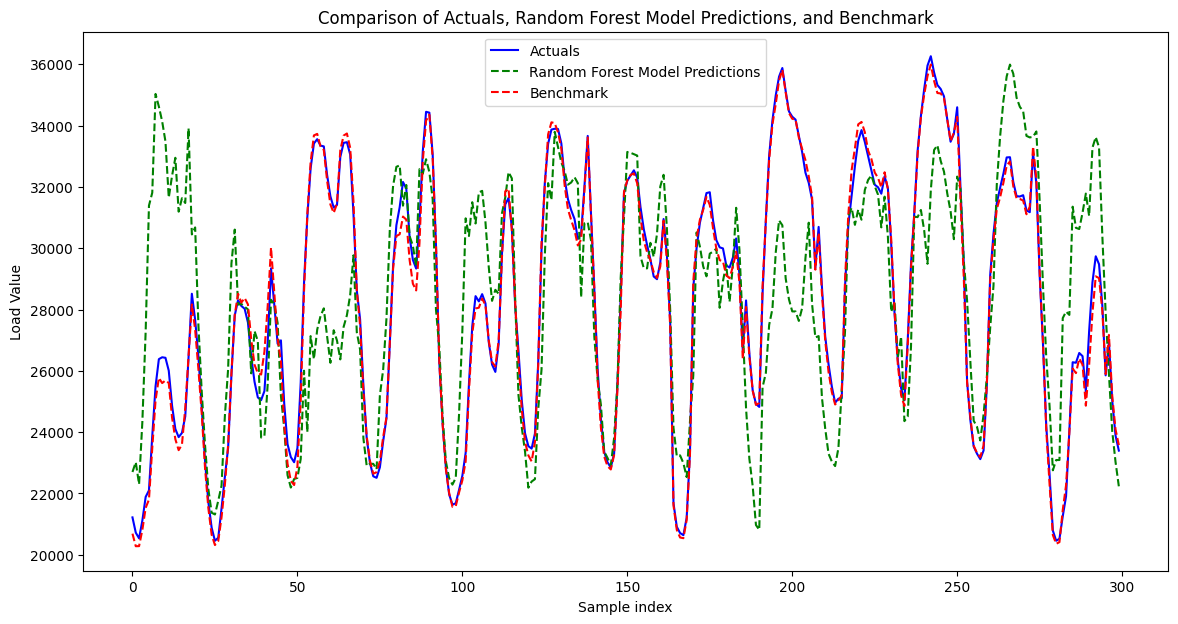

In [501]:
# Sample for visualization (e.g., 200 points)
sample_size = 300
indices = range(sample_size)

plt.figure(figsize=(14, 7))

# Plot actuals
plt.plot(indices, y_test[:sample_size], label="Actuals", color="blue")

# Plot RF model predictions
plt.plot(indices, rf_y_pred[:sample_size], label="Random Forest Model Predictions", color="green", linestyle="--")

# Plot benchmark
plt.plot(indices, benchmark_test[:sample_size], label="Benchmark", color="red", linestyle="--")

plt.title("Comparison of Actuals, Random Forest Model Predictions, and Benchmark")
plt.xlabel("Sample index")
plt.ylabel("Load Value")
plt.legend()
plt.show()


Upon visual inspection of the model's predictions, the Random Forest model seems to capture the overall trend and shape of the load effectively. However, it struggles with the magnitude, both underpredicting and overpredicting the peak load values, similar to the KNN model. It is also a bit more "jaggedy" than it needs to be at times. I am wondering if this could be due to overfitting, ie that it is capturing too much noise in the training data, rather than an underlying trend.

## Random Forest vs. KNN Model, Plotted

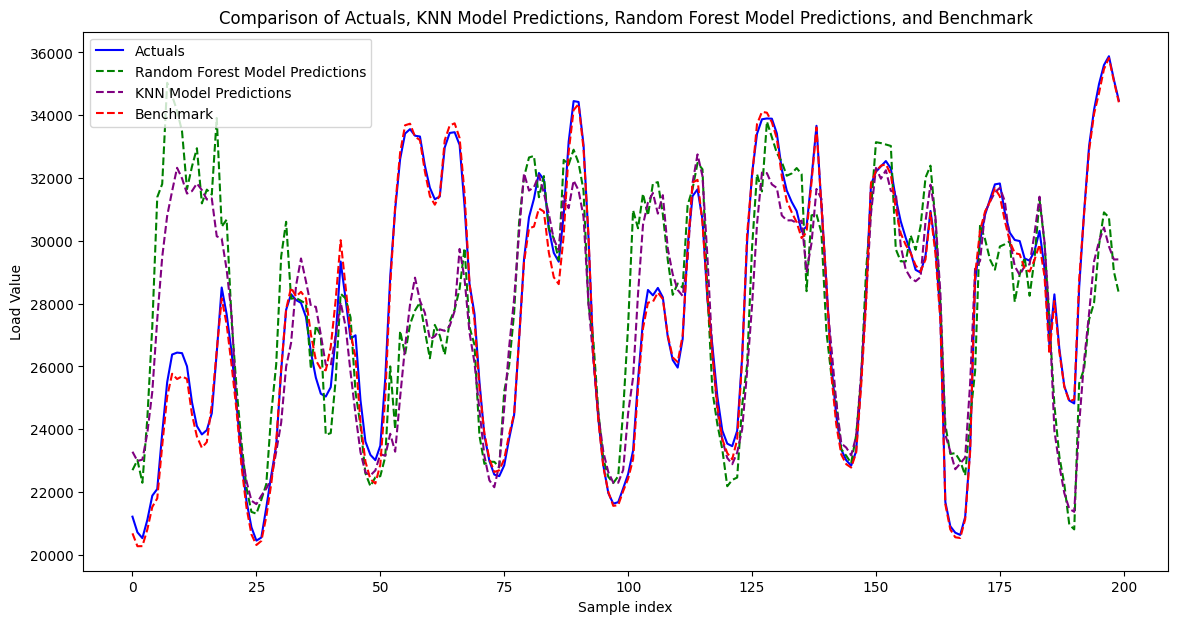

In [505]:
# Sample for visualization (e.g., 200 points)
sample_size = 200
indices = range(sample_size)

plt.figure(figsize=(14, 7))

# Plot actuals
plt.plot(indices, y_test[:sample_size], label="Actuals", color="blue")

# Plot RF model predictions
plt.plot(indices, rf_y_pred[:sample_size], label="Random Forest Model Predictions", color="green", linestyle="--")

# Plot KNN predictions (assuming you have stored them in a variable knn_y_pred)
plt.plot(indices, knn_y_pred[:sample_size], label="KNN Model Predictions", color="purple", linestyle="--")


# Plot benchmark
plt.plot(indices, benchmark_test[:sample_size], label="Benchmark", color="red", linestyle="--")

plt.title("Comparison of Actuals, KNN Model Predictions, Random Forest Model Predictions, and Benchmark")
plt.xlabel("Sample index")
plt.ylabel("Load Value")
plt.legend()
plt.show()


Both models tend to over- and under-predict at similar points in time, which is interesting. Perhaps this indicates something crucial about the features being selected rather than the model itself. 

# Insights & Next Steps